<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2025notebooks/2025_1212qiita20_agent57.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.前処理

## 0-1. GoogleColab用の前処理

In [ ]:
#installing dependencies
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null

!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'


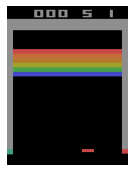

In [ ]:
# draw TEST
import gym
import numpy as np

env = gym.make('Breakout-v4')
#env = gym.make('CartPole-v0')
obs = env.reset()
frames = []
t = 0
for i in range(1):
  obs = env.reset()
  done = False
  while not done and t < 200:
    frames.append(env.render(mode = 'rgb_array'))
    obs, r, done, _ = env.step(env.action_space.sample())
    t += 1

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

## 0-2. pipインストール

In [ ]:
!pip install keras-rl
!pip install pygame

# 1.各クラスの定義

## processor.py

In [ ]:
import rl.core
from PIL import Image, ImageDraw
import numpy as np

import math


class PendulumProcessorForDQN(rl.core.Processor):
    """
    https://github.com/openai/gym/wiki/Pendulum-v0
    """

    def __init__(self,
            reward_clip=(-0.5, 1),   # None is disable
            action_division=5,
            enable_image=False,
            image_shape=(84,84)
        ):
        self.reward_clip = reward_clip
        self.enable_image = enable_image
        self.image_shape = image_shape
        self.nb_actions = action_division

        # -2 ～ 2 で分割する
        self.actid_to_value = {}
        for i in range(action_division):
            n = (4.0/(action_division-1))*i - 2.0
            self.actid_to_value[i] = [n]

        # 最低報酬
        theta = math.pi
        theta_dt = 8
        action = 2
        self.reward_low = -(theta**2 + 0.1*theta_dt**2 + 0.001*action**2)
        self.reward_high = 0

    def process_observation(self, observation):
        if not self.enable_image:
            return observation
        return self._get_rgb_state(observation)  # reshazeせずに返す

    def process_action(self, action):
        return self.actid_to_value[action]

    def get_keys_to_action(self):
        return {
            ():2,
            (ord('z'),):0,
            (ord('x'),):1,
            (ord('c'),):3,
            (ord('v'),):4,
        }

    def process_reward(self, reward):
        if self.reward_clip is None:
            return reward

        # min max normarization
        reward = ((reward - self.reward_low) / (self.reward_high - self.reward_low))*(self.reward_clip[1] - self.reward_clip[0]) + self.reward_clip[0]
        return reward

    # 状態（x,y座標）から対応画像を描画する関数
    def _get_rgb_state(self, state):
        img_size = self.image_shape[0]
        h_size = img_size/2.0

        img = Image.new("RGB", self.image_shape, (255, 255, 255))
        dr = ImageDraw.Draw(img)

        # 棒の長さ
        l = img_size/4.0 * 3.0/ 2.0

        # 棒のラインの描写
        dr.line(((h_size - l * state[1], h_size - l * state[0]), (h_size, h_size)), (0, 0, 0), 1)

        # 棒の中心の円を描写（それっぽくしてみた）
        buff = img_size/32.0
        dr.ellipse(((h_size - buff, h_size - buff), (h_size + buff, h_size + buff)),
                   outline=(0, 0, 0), fill=(255, 0, 0))

        # 画像の一次元化（GrayScale化）とarrayへの変換
        pilImg = img.convert("L")
        img_arr = np.asarray(pilImg)

        # 画像の規格化
        img_arr = img_arr/255.0

        return img_arr



class CartPoleProcessor(rl.core.Processor):
    """
    https://github.com/openai/gym/wiki/CartPole-v0
    """

    def __init__(self, enable_reward_step=False):
        self.enable_reward_step = enable_reward_step
        self.step = 0

    def process_step(self, observation, reward, done, info):
        observation = self.process_observation(observation)
        reward = self.process_reward(reward)
        info = self.process_info(info)

        if not self.enable_reward_step:
            return observation, reward, done, info

        self.step += 1

        if done :
            if self.step > 195:
                reward = 1
            else:
                reward = -1
            self.step = 0
        else:
            reward = 0

        return observation, reward, done, info

    def get_keys_to_action(self):
        return {
            (ord('a'),):0,
            (ord('d'),):1,
        }

class AcrobotProcessor(rl.core.Processor):
    def __init__(self, enable_reward_step=False):
        self.enable_reward_step = enable_reward_step
        self.step = 0


    def process_step(self, observation, reward, done, info):
        observation = self.process_observation(observation)
        reward = self.process_reward(reward)
        info = self.process_info(info)

        if not self.enable_reward_step:
            return observation, reward, done, info

        self.step += 1
        if done :
            reward = 500-self.step
            self.step = 0

        else:
            reward = 0

        return observation, reward, done, info


class AtariProcessor(rl.core.Processor):
    def __init__(self,
            reshape_size=(84, 84),
            enable_clip=False,
            max_steps=0,
            freeze_check=0,
            no_reward_check=0,
            penalty_reward=0,
        ):
        self.image_shape = reshape_size
        self.enable_clip = enable_clip
        self.max_steps = max_steps
        self.freeze_check = freeze_check
        self.no_reward_check = no_reward_check
        self.penalty_reward = penalty_reward
        self._init()

    def _init(self):
        self.step = 0
        if self.freeze_check > 0:
            self.recent_observations = [
                np.zeros(self.image_shape) for _ in range(self.freeze_check)
            ]
        if self.no_reward_check > 0:
            self.no_reward_count = 0


    def process_step(self, observation, reward, done, info):
        observation = self.process_observation(observation)
        reward = self.process_reward(reward)
        info = self.process_info(info)

        # freeze check
        if self.freeze_check > 0:
            self.recent_observations.pop(0)
            self.recent_observations.append(observation)
            # 全部同じ画像なら freeze 判定
            f = True
            for i in range(self.freeze_check-1):
                if not np.array_equal(self.recent_observations[i], self.recent_observations[i+1]):
                    f = False
                    break
            if f:
                self._init()
                done = True
                reward = self.penalty_reward

        # no_reward_check
        if self.no_reward_check > 0:
            if reward == 0:
                self.no_reward_count += 1
            else:
                self.no_reward_count = 0
            if self.no_reward_count > self.no_reward_check:
                self._init()
                done = True
                reward = self.penalty_reward

        # step制限確認
        if self.max_steps > 0:
            self.step += 1
            if self.step >= self.max_steps:
                self._init()
                done = True

        return observation, reward, done, info

    def process_action(self, action):
        return action

    def process_observation(self, observation):
        img = Image.fromarray(observation)
        img = img.resize(self.image_shape).convert('L')  # resize and convert to grayscale
        return np.array(img) / 255

    def process_reward(self, reward):
        if self.enable_clip:
            return np.clip(reward, -1., 1.)
        return reward

class AtariBreakout(AtariProcessor):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.n = 0
        self.nb_actions = 3

    def process_action(self, action):
        self.n += 1
        if self.n % 10 == 0:
            return 1
        keys = [0, 2, 3]
        return keys[action]

    def get_keys_to_action(self):
        return {
            ():0,
            (ord('d'),):1,
            (ord('a'),):2,
        }


class AtariPong(AtariProcessor):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.nb_actions = 3


    def process_action(self, action):
        keys = [0, 2, 3]
        return keys[action]

    def process_step(self, observation, reward, done, info):
        observation, reward, done, info = super().process_step(observation, reward, done, info)
        if reward != 0:
            done = True
        return observation, reward, done, info

    def get_keys_to_action(self):
        return {
            ():0,
            (ord('a'),):1,
            (ord('d'),):2,
        }



Using TensorFlow backend.


## common.py

In [ ]:
import tensorflow as tf
from keras import backend as K
import numpy as np

import enum
import math
import os
import random



def rescaling(x, epsilon=0.001):
    if x == 0:
        return 0
    n = math.sqrt(abs(x)+1) - 1
    return np.sign(x)*n + epsilon*x

def rescaling_inverse(x, epsilon=0.001):
    if x == 0:
        return 0
    n = math.sqrt(1 + 4*epsilon*(abs(x)+1+epsilon)) - 1
    return np.sign(x)*( n/(2*epsilon) - 1)

def sigmoid(x, a=1):
    return 1 / (1 + np.exp(-a * x))

# copy from https://qiita.com/okotaku/items/8d682a11d8f2370684c9
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    #session_conf = tf.compat.v1.ConfigProto(
    #    intra_op_parallelism_threads=1,
    #    inter_op_parallelism_threads=1
    #)
    #sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    #tf.compat.v1.keras.backend.set_session(sess)


def create_beta_list(policy_num, max_beta=0.3):
    assert policy_num > 0
    beta_list = []
    for i in range(policy_num):
        if i == 0:
            b = 0
        elif i == policy_num-1:
            b = max_beta
        else:
            b = 10 * (2*i-(policy_num-2)) / (policy_num-2)
            b = max_beta * sigmoid(b)
        beta_list.append(b)
    return beta_list


def create_gamma_list_ngu(policy_num, gamma_min=0.99, gamma_max=0.997):
    assert policy_num > 0
    if policy_num == 1:
        return [gamma_min]
    if policy_num == 2:
        return [gamma_min, gamma_max]
    gamma_list = []
    for i in range(policy_num):
        g = (policy_num - 1 - i)*np.log(1 - gamma_max) + i*np.log(1 - gamma_min)
        g /= policy_num - 1
        g = 1 - np.exp(g)
        gamma_list.append(g)
    return gamma_list


def create_gamma_list_agent57(policy_num, gamma0=0.9999, gamma1=0.997, gamma2=0.99):
    assert policy_num > 0
    gamma_list = []
    for i in range(policy_num):
        if i == 1:
            g = gamma0
        elif 2 <= i and i <= 6:
            g = 10*((2*i-6)/6)
            g = gamma1 + (gamma0 - gamma1)*sigmoid(g)
        elif i == 7:
            g = gamma1
        else:
            g = (policy_num-9)*np.log(1-gamma1) + (i-8)*np.log(1-gamma2)
            g /= policy_num-9
            g = 1-np.exp(g)
        gamma_list.append(g)
    return gamma_list


## policy.py

In [ ]:
from keras.models import model_from_json
from keras.optimizers import Adam
import numpy as np

import random
import math



class Policy():
    """ Abstract base class for all implemented Policy. """
    def select_action(self, agent):
        raise NotImplementedError()


class EpsilonGreedy(Policy):
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def select_action(self, agent):
        if self.epsilon > random.random():
            # アクションをランダムに選択
            action = random.randint(0, agent.nb_actions-1)
        else:
            # 評価が最大のアクションを選択
            action = np.argmax(agent.get_qvals())
        return action


class EpsilonGreedyActor(EpsilonGreedy):
    def __init__(self, actor_index, actors_length, epsilon=0.4, alpha=7):
        if actors_length <= 1:
            tmp = epsilon ** (1 + alpha)
        else:
            tmp = epsilon ** (1 + actor_index/(actors_length-1)*alpha)
        super().__init__(epsilon=tmp)


class AnnealingEpsilonGreedy(Policy):
    """ native dqn pilocy
    https://arxiv.org/abs/1312.5602
    """

    def __init__(self,
            initial_epsilon=1,  # 初期ε
            final_epsilon=0.1,  # 最終状態でのε
            exploration_steps=1_000_000  # 初期→最終状態になるまでのステップ数
        ):
        self.epsilon_step = (initial_epsilon - final_epsilon) / exploration_steps
        self.initial_epsilon = initial_epsilon
        self.final_epsilon = final_epsilon

    def select_action(self, agent):

        # epsilon の計算
        epsilon = self.initial_epsilon - agent.step * self.epsilon_step
        if epsilon < self.final_epsilon:
            epsilon = self.final_epsilon

        if epsilon > random.random():
            # アクションをランダムに選択
            action = random.randint(0, agent.nb_actions-1)
        else:
            # 評価が最大のアクションを選択
            action = np.argmax(agent.get_qvals())
        return action


class SoftmaxPolicy(Policy):

    def select_action(self, agent):
        qvals = agent.get_qvals()
        exp_x = np.exp(qvals)

        vals = []
        for i in range(agent.nb_actions):
            # softmax 値以下の乱数を生成
            vals.append( random.uniform(0, exp_x[i]) )

        # 乱数の結果一番大きいアクションを選択
        action = np.argmax(vals)
        return action



## memory.py

In [ ]:
import numpy as np

import random
import bisect
import math


class Memory():
    """ Abstract base class for all implemented Memory. """
    def add(self, exp, priority=0):
        raise NotImplementedError()

    def update(self, idx, exp, priority):
        raise NotImplementedError()

    def sample(self, batch_size, steps):
        raise NotImplementedError()

    def __len__(self):
        raise NotImplementedError()

    def get_memorys(self):
        raise NotImplementedError()

    def set_memorys(self, data):
        raise NotImplementedError()


class _bisect_wrapper():
    def __init__(self, data, priority):
        self.data = data
        self.priority = priority

    def __lt__(self, o):  # a<b
        return self.priority < o.priority


class ReplayMemory(Memory):
    """ ReplayMemory
    https://arxiv.org/abs/1312.5602
    """

    @staticmethod
    def getName():
        return "ReplayMemory"

    def __init__(self, capacity=1_000_000):
        self.capacity = capacity
        self.index = 0
        self.buffer = []

    def add(self, exp, priority=0):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.index] = exp
        self.index = (self.index + 1) % self.capacity

    def update(self, idx, exp, priority):
        pass

    def sample(self, batch_size, steps):
        batchs = random.sample(self.buffer, batch_size)
        indexes = [ 0 for _ in range(batch_size)]
        weights = [ 1 for _ in range(batch_size)]
        return (indexes, batchs, weights)

    def __len__(self):
        return len(self.buffer)

    def get_memorys(self):
        return self.buffer[:]

    def set_memorys(self, data):
        for d in data:
            self.add(d)


class PERGreedyMemory(Memory):
    @staticmethod
    def getName():
        return "PERGreedyMemory"

    def __init__(self, capacity=1_000_000):
        self.buffer = []
        self.capacity = capacity
        self.max_priority = 1

    def add(self, exp, priority=0):
        if priority == 0:
            priority = self.max_priority
        if self.capacity <= len(self.buffer):
            # 上限より多い場合は要素を削除
            self.buffer.pop(0)

        # priority は最初は最大を選択
        exp = _bisect_wrapper(exp, priority)
        bisect.insort(self.buffer, exp)

    def update(self, idx, exp, priority):
        exp = _bisect_wrapper(exp, priority)
        bisect.insort(self.buffer, exp)

        if self.max_priority < priority:
            self.max_priority = priority

    def sample(self, batch_size, step):
        # 取り出す(学習後に再度追加)
        batchs = [self.buffer.pop().data for _ in range(batch_size)]
        indexes = [ 0 for _ in range(batch_size)]
        weights = [ 1 for _ in range(batch_size)]
        return (indexes, batchs, weights)

    def __len__(self):
        return len(self.buffer)

    def get_memorys(self):
        return [(d.data, d.priority) for d in self.buffer]

    def set_memorys(self, data):
        self.buffer = []
        for d in data:
            self.add(d[0], d[1])


class SumTree():
    """
    copy from https://github.com/jaromiru/AI-blog/blob/5aa9f0b/SumTree.py
    """

    def __init__(self, capacity):
        self.capacity = capacity
        self.write = 0
        self.tree = [ 0 for _ in range( 2*capacity - 1 )]
        self.data = [ None for _ in range(capacity)]

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])


class PERProportionalMemory(Memory):
    @staticmethod
    def getName():
        return "PERProportionalMemory"

    def __init__(self,
            capacity=1_000_000,
            alpha=0.6,
            beta_initial=0.4,
            beta_steps=1_000_000,
            enable_is=False
        ):
        self.capacity = capacity
        self.tree = SumTree(capacity)

        self.beta_initial = beta_initial
        self.beta_steps = beta_steps
        self.enable_is = enable_is
        self.alpha = alpha

        self.size = 0
        self.max_priority = 1

    def add(self, exp, priority=0, _alpha_skip=False):
        if priority == 0:
            priority = self.max_priority
        if not _alpha_skip:
            priority = priority ** self.alpha
        self.tree.add(priority, exp)
        self.size += 1
        if self.size > self.capacity:
            self.size = self.capacity

    def update(self, index, exp, priority):
        priority = priority ** self.alpha
        self.tree.update(index, priority)

        if self.max_priority < priority:
            self.max_priority = priority

    def sample(self, batch_size, step):
        indexes = []
        batchs = []
        weights = np.empty(batch_size, dtype='float32')

        if self.enable_is:
            # βは最初は低く、学習終わりに1にする
            beta = self.beta_initial + (1 - self.beta_initial) * step / self.beta_steps
            if beta > 1:
                beta = 1

        total = self.tree.total()
        for i in range(batch_size):

            # indexesにないものを追加
            for _ in range(100):  # for safety
                r = random.random()*total
                (idx, priority, experience) = self.tree.get(r)
                if idx not in indexes:
                    break

            indexes.append(idx)
            batchs.append(experience)

            if self.enable_is:
                # 重要度サンプリングを計算
                weights[i] = (self.size * priority / total) ** (-beta)
            else:
                weights[i] = 1  # 無効なら1

        if self.enable_is:
            # 安定性の理由から最大値で正規化
            weights = weights / weights.max()

        return (indexes ,batchs, weights.tolist())

    def __len__(self):
        return self.size

    def get_memorys(self):
        data = []
        for i in range(self.size):
            d = self.tree.data[i]
            p = self.tree.tree[i+self.capacity-1]
            data.append([d, p])

        return data

    def set_memorys(self, data):
        self.tree = SumTree(self.capacity)
        self.size = 0

        for d in data:
            self.add(d[0], d[1], _alpha_skip=True)


def rank_sum(k, a):
    return k*( 2+(k-1)*a )/2

def rank_sum_inverse(k, a):
    if a == 0:
        return k
    t = a-2 + math.sqrt((2-a)**2 + 8*a*k)
    return t/(2*a)

class PERRankBaseMemory(Memory):
    @staticmethod
    def getName():
        return "PERRankBaseMemory"

    def __init__(self,
            capacity=1_000_000,
            alpha=0.6,
            beta_initial=0.4,
            beta_steps=1_000_000,
            enable_is=False
        ):
        self.capacity = capacity
        self.buffer = []
        self.alpha = alpha

        self.beta_initial = beta_initial
        self.beta_steps = beta_steps
        self.enable_is = enable_is

        self.max_priority = 1

    def add(self, exp, priority=0):
        if priority == 0:
            priority = self.max_priority
        if self.capacity <= len(self.buffer):
            # 上限より多い場合は要素を削除
            self.buffer.pop(0)

        exp = _bisect_wrapper(exp, priority)
        bisect.insort(self.buffer, exp)

    def update(self, index, exp, priority):
        exp = _bisect_wrapper(exp, priority)
        bisect.insort(self.buffer, exp)

        if self.max_priority < priority:
            self.max_priority = priority

    def sample(self, batch_size, step):
        indexes = []
        batchs = []
        weights = np.empty(batch_size, dtype='float32')

        if self.enable_is:
            # βは最初は低く、学習終わりに1にする。
            beta = self.beta_initial + (1 - self.beta_initial) * step / self.beta_steps
            if beta > 1:
                beta = 1

        # 合計値をだす
        buffer_size = len(self.buffer)
        total = rank_sum(buffer_size, self.alpha)

        # index_lst
        index_lst = []
        for _ in range(batch_size):

            # index_lstにないものを追加
            for _ in range(100):  # for safety
                r = random.random()*total
                index = rank_sum_inverse(r, self.alpha)
                index = int(index)  # 整数にする(切り捨て)
                if index not in index_lst:
                    index_lst.append(index)
                    break

        #assert len(index_lst) == batch_size
        index_lst.sort()

        for i, index in enumerate(reversed(index_lst)):
            o = self.buffer.pop(index)  # 後ろから取得するのでindexに変化なし
            batchs.append(o.data)
            indexes.append(index)

            if self.enable_is:
                # 重要度サンプリングを計算
                # 確率を計算(iでの区間/total)
                r1 = rank_sum(index+1, self.alpha)
                r2 = rank_sum(index, self.alpha)
                priority = (r1-r2) / total
                w = (buffer_size * priority) ** (-beta)
                weights[i] = w
            else:
                weights[i] = 1  # 無効なら1

        if self.enable_is:
            if True:
                # 安定性の理由から最大値で正規化
                weights = weights / weights.max()
            else:
                for i in range(len(weights)):
                    if weights[i] > 1:
                        weights[i] = 1

        return (indexes, batchs, weights.tolist())

    def __len__(self):
        return len(self.buffer)

    def get_memorys(self):
        return [(d.data, d.priority) for d in self.buffer]

    def set_memorys(self, data):
        self.buffer = []
        self.max_priority = 1
        for d in data:
            self.add(d[0], d[1])


class EpisodeMemory(Memory):
    def __init__(self, memory, verbose):
        self.max_reward = None
        self.memory = memory
        self.verbose = verbose

    def add_episode(self, episode, total_reward):
        if self.memory is None:
            return
        f = True
        if self.max_reward is None:
            self.max_reward = total_reward
        elif self.max_reward <= total_reward:
            f = self.max_reward < total_reward
            self.max_reward = total_reward
        else:
            return
        for e in episode:
            if len(e) == 5:
                self.memory.add(e, e[4])
            else:
                self.memory.add(e)
        if self.verbose > 0 and f:
            print("episode add, reward:{:.4f} length: {} on_memory: {}".format(total_reward, len(episode), len(self.memory)))

    def update(self, idx, exp, priority):
        self.memory.update(idx, exp, priority)

    def sample(self, batch_size, step):
        return self.memory.sample(batch_size, step)

    def __len__(self):
        if self.memory is None:
            return 0
        return len(self.memory)

    def get_memorys(self):
        if self.memory is None:
            return None
        d = {
            "max": self.max_reward,
            "memory": self.memory.get_memorys()
        }
        return d

    def set_memorys(self, data):
        if self.memory is None:
            return None
        self.max_reward = data["max"]
        self.memory.set_memorys(data["memory"])




class MemoryFactory():
    memories = [
        ReplayMemory,
        PERGreedyMemory,
        PERRankBaseMemory,
        PERProportionalMemory,
    ]
    @staticmethod
    def create(name, kwargs):

        for m in MemoryFactory.memories:
            if m.getName() == name:
                return m(**kwargs)

        names = []
        for m in MemoryFactory.memories:
            names.append(m.getName())
        raise ValueError('memories is [{}]'.format(",".join(names)))




## model.py

In [ ]:
from keras.models import Model
from keras.layers import Input, Flatten, Permute, TimeDistributed, LSTM, Dense, Concatenate, Reshape, Lambda, Conv2D, MaxPooling2D, Activation, Add
import tensorflow as tf
from keras import backend as K
import numpy as np

import enum

def clipped_error_loss(y_true, y_pred):
    err = y_true - y_pred  # エラー
    L2 = 0.5 * K.square(err)
    L1 = K.abs(err) - 0.5

    # エラーが[-1,1]区間ならL2、それ以外ならL1を選択する。
    loss = tf.where((K.abs(err) < 1.0), L2, L1)   # Keras does not cover where function in tensorflow :-(
    return K.mean(loss)


class InputType(enum.Enum):
    VALUES = 1    # 画像無し
    GRAY_2ch = 3  # (width, height)
    GRAY_3ch = 4  # (width, height, 1)
    COLOR = 5     # (width, height, ch)

class DuelingNetwork(enum.Enum):
    AVERAGE = 0
    MAX = 1
    NAIVE = 2

class LstmType(enum.Enum):
    NONE = 0
    STATELESS = 1
    STATEFUL = 2

class ModelBuilder():
    def __init__(self,
            input_shape,
            input_type,
            image_model,
            image_model_emb,
            image_model_rnd,
            batch_size,
            nb_actions,
            input_sequence,
            enable_dueling_network,
            dueling_network_type,
            dense_units_num,
            lstm_type,
            lstm_units_num,
            policy_num,
        ):
        self.input_shape = input_shape
        self.input_type = input_type
        self.image_model = image_model
        self.image_model_emb = image_model_emb
        self.image_model_rnd = image_model_rnd
        self.batch_size = batch_size
        self.nb_actions = nb_actions
        self.input_sequence = input_sequence
        self.enable_dueling_network = enable_dueling_network
        self.dueling_network_type = dueling_network_type
        self.dense_units_num = dense_units_num
        self.lstm_type = lstm_type
        self.lstm_units_num = lstm_units_num
        self.policy_num = policy_num

        if self.image_model_emb is None:
            self.image_model_emb = self.image_model
        if self.image_model_rnd is None:
            self.image_model_rnd = self.image_model

        if input_type == InputType.GRAY_2ch or input_type == InputType.GRAY_3ch or input_type == InputType.COLOR:
            assert self.image_model is not None

            # 画像入力の制約
            # LSTMを使う場合: 画像は(w,h,ch)で入力できます。
            # LSTMを使わない場合：
            #   input_sequenceが1：全て使えます。
            #   input_sequenceが1以外：GRAY_2ch のみ使えます。
            if lstm_type == LstmType.NONE and input_sequence != 1:
                assert (input_type == InputType.GRAY_2ch), "input_iimage can use GRAY_2ch."

    def _build_input_layer(self):

        if self.input_type == InputType.VALUES:
            if self.lstm_type != LstmType.STATEFUL:
                c = input_ = Input(
                    shape=(self.input_sequence,) + self.input_shape)
            else:
                c = input_ = Input(
                    batch_shape=(self.batch_size, self.input_sequence) + self.input_shape)
        elif self.input_type == InputType.GRAY_2ch:
            if self.lstm_type != LstmType.STATEFUL:
                c = input_ = Input(
                    shape=(self.input_sequence,) + self.input_shape)
            else:
                c = input_ = Input(
                    batch_shape=(self.batch_size, self.input_sequence) + self.input_shape)
        else:
            if self.lstm_type != LstmType.STATEFUL:
                c = input_ = Input(shape=self.input_shape)
            else:
                c = input_ = Input(
                    batch_shape=(self.batch_size, self.input_sequence) + self.input_shape)

        return c, input_

    def _build_image_layer(self, image_model, lstm_type, c1, c2=None):
        if self.input_type == InputType.VALUES:
            if lstm_type == LstmType.NONE:
                c1 = Flatten()(c1)
                if c2 is not None:
                    c2 = Flatten()(c2)
            else:
                c1 = TimeDistributed(Flatten())(c1)
                if c2 is not None:
                    c2 = TimeDistributed(Flatten())(c2)
        else:
            if lstm_type == LstmType.NONE:
                is_lstm = False
                if self.input_type == InputType.GRAY_2ch:
                    # (input_seq, w, h) ->(w, h, input_seq)
                    c1 = Permute((2, 3, 1))(c1)
                    if c2 is not None:
                        c2 = Permute((2, 3, 1))(c2)
            elif lstm_type == LstmType.STATELESS or lstm_type == LstmType.STATEFUL:
                is_lstm = True
                if self.input_type == InputType.GRAY_2ch:
                    # (time steps, w, h) -> (time steps, w, h, ch)
                    c1 = Reshape((self.input_sequence, ) + self.input_shape + (1,) )(c1)
                    if c2 is not None:
                        c2 = Reshape((self.input_sequence, ) + self.input_shape + (1,) )(c2)
            else:
                raise ValueError('lstm_type is undefined: {}'.format(lstm_type))
            c1, c2 = image_model.create_image_model(c1, is_lstm, c2)

        if c2 is None:
            return c1
        else:
            return c1, c2


    def build_actval_func_model(self, optimizer, enable_uvfa):
        c, input_ = self._build_input_layer()
        c = self._build_image_layer(self.image_model, self.lstm_type, c)

        if enable_uvfa:
            if self.lstm_type == LstmType.NONE:
                c2 = input2 = Input(shape=(self.policy_num,))
            elif self.lstm_type == LstmType.STATELESS:
                c2 = input2 = Input(shape=(self.input_sequence, self.policy_num,))
            else:
                c2 = input2 = Input(batch_shape=(self.batch_size, self.input_sequence, self.policy_num))
            c = Concatenate()([c, c2])

        # lstm layer
        if self.lstm_type == LstmType.STATELESS:
            c = LSTM(self.lstm_units_num, name="lstm")(c)
        elif self.lstm_type == LstmType.STATEFUL:
            c = LSTM(self.lstm_units_num, stateful=True, name="lstm")(c)

        # dueling network
        if self.enable_dueling_network:
            # value
            v = Dense(self.dense_units_num, activation="relu")(c)
            v = Dense(1, name="v")(v)

            # advance
            adv = Dense(self.dense_units_num, activation='relu')(c)
            adv = Dense(self.nb_actions, name="adv")(adv)

            # 連結で結合
            c = Concatenate()([v,adv])
            if self.dueling_network_type == DuelingNetwork.AVERAGE:
                c = Lambda(lambda a: K.expand_dims(a[:, 0], -1) + a[:, 1:] - K.mean(a[:, 1:], axis=1, keepdims=True), output_shape=(self.nb_actions,))(c)
            elif self.dueling_network_type == DuelingNetwork.MAX:
                c = Lambda(lambda a: K.expand_dims(a[:, 0], -1) + a[:, 1:] - K.max(a[:, 1:], axis=1, keepdims=True), output_shape=(self.nb_actions,))(c)
            elif self.dueling_network_type == DuelingNetwork.NAIVE:
                c = Lambda(lambda a: K.expand_dims(a[:, 0], -1) + a[:, 1:], output_shape=(self.nb_actions,))(c)
            else:
                raise ValueError('dueling_network_type is undefined')
        else:
            c = Dense(self.dense_units_num, activation="relu")(c)
            c = Dense(self.nb_actions, activation="linear", name="adv")(c)

        if enable_uvfa:
            model = Model([input_, input2], c)
        else:
            model = Model(input_, c)

        if optimizer is not None:
            model.compile(loss=clipped_error_loss, optimizer=optimizer)

        return model


    def build_embedding_model(self):
        c, input_ = self._build_input_layer()
        c = self._build_image_layer(self.image_model_emb, LstmType.NONE, c)

        c = Dense(32, activation="relu", name="emb_dense")(c)

        model = Model(input_, c)
        # 学習しないので compile は不要
        return model


    def build_embedding_model_train(self, optimizer):
        c1, input1 = self._build_input_layer()
        c2, input2 = self._build_input_layer()

        c1, c2 = self._build_image_layer(self.image_model_emb, LstmType.NONE, c1, c2)

        d = Dense(32, activation="relu", name="emb_dense")
        c1 = d(c1)
        c2 = d(c2)

        c = Concatenate()([c1, c2])
        c = Dense(128, activation="relu")(c)
        c = Dense(self.nb_actions, activation="softmax")(c)

        model = Model([input1, input2], c)
        model.compile(loss='mean_squared_error', optimizer=optimizer)

        return model

    def sync_embedding_model(self, train_model, target_model):
        if self.image_model_emb is not None:
            for name in self.image_model_emb.get_layer_names():
                train_layer = train_model.get_layer(name)
                target_layer = target_model.get_layer(name)
                target_layer.set_weights(train_layer.get_weights())
        train_layer = train_model.get_layer("emb_dense")
        target_layer = target_model.get_layer("emb_dense")
        target_layer.set_weights(train_layer.get_weights())


    def build_rnd_model(self, optimizer):
        c, input_ = self._build_input_layer()
        c = self._build_image_layer(self.image_model_rnd, LstmType.NONE, c)

        c = Dense(128)(c)

        model = Model(input_, c)
        if optimizer is not None:
            model.compile(loss='mean_squared_error', optimizer=optimizer)

        return model


class ImageModel():
    """ Abstract base class for all implemented ImageModel. """
    def get_layer_names(self):
        raise NotImplementedError()

    def create_image_model(self, c1, is_lstm, c2=None):
        raise NotImplementedError()


class DQNImageModel(ImageModel):
    """ native dqn image model
    https://arxiv.org/abs/1312.5602
    """

    def get_layer_names(self):
        return [
            "c1",
            "c2",
            "c3",
        ]

    def create_image_model(self, c1, is_lstm, c2=None):

        if not is_lstm:
            l = Conv2D(32, (8, 8), strides=(4, 4), padding="same", activation="relu", name="c1")
            c1 = l(c1)
            if c2 is not None:
                c2 = l(c2)

            l = Conv2D(64, (4, 4), strides=(2, 2), padding="same", activation="relu", name="c2")
            c1 = l(c1)
            if c2 is not None:
                c2 = l(c2)

            l = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="c3")
            c1 = l(c1)
            if c2 is not None:
                c2 = l(c2)

            c1 = Flatten()(c1)
            if c2 is not None:
                c2 = Flatten()(c2)

        else:
            l = TimeDistributed(Conv2D(32, (8, 8), strides=(4, 4), padding="same", activation="relu"), name="c1")
            c1 = l(c1)
            if c2 is not None:
                c2 = l(c2)

            l = TimeDistributed(Conv2D(64, (4, 4), strides=(2, 2), padding="same", activation="relu"), name="c2")
            c1 = l(c1)
            if c2 is not None:
                c2 = l(c2)

            l = TimeDistributed(Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu"), name="c3")
            c1 = l(c1)
            if c2 is not None:
                c2 = l(c2)

            c1 = TimeDistributed(Flatten())(c1)
            if c2 is not None:
                c2 = TimeDistributed(Flatten())(c2)

        return c1, c2


class R2D3ImageModel(ImageModel):
    """ R2D3 image model
    https://arxiv.org/abs/1909.01387
    """

    def __init__(self):
        self.names = []

    def get_layer_names(self):
        return self.names

    def create_image_model(self, c1, is_lstm, c2=None):
        self.names = []

        c1, c2 = self._resblock(c1, 16, is_lstm, c2)
        c1, c2 = self._resblock(c1, 32, is_lstm, c2)
        c1, c2 = self._resblock(c1, 32, is_lstm, c2)

        c1 = Activation("relu")(c1)
        if c2 is not None:
            c2 = Activation("relu")(c2)

        if not is_lstm:
            c1 = Flatten()(c1)
            if c2 is not None:
                c2 = Flatten()(c2)
        else:
            c1 = TimeDistributed(Flatten())(c1)
            if c2 is not None:
                c2 = TimeDistributed(Flatten())(c2)

        return c1, c2


    def _resblock(self, c1, n_filter, is_lstm, c2):
        if not is_lstm:
            n = "l{}".format(len(self.names))
            self.names.append(n)
            l = Conv2D(n_filter, (3, 3), strides=(1,1), padding="same", name=n)
            c1 = l(c1)
            if c2 is not None:
                c2 = l(c2)
            l = MaxPooling2D((3, 3), strides=(2,2), padding='same')
            c1 = l(c1)
            if c2 is not None:
                c2 = l(c2)
        else:
            n = "l{}".format(len(self.names))
            self.names.append(n)
            l = TimeDistributed(Conv2D(n_filter, (3, 3), strides=(1,1), padding="same"), name=n)
            c1 = l(c1)
            if c2 is not None:
                c2 = l(c2)
            l = TimeDistributed(MaxPooling2D((3, 3), strides=(2,2), padding='same'))
            c1 = l(c1)
            if c2 is not None:
                c2 = l(c2)

        c1, c2 = self._residual_block(c1, n_filter, is_lstm, c2)
        c1, c2 = self._residual_block(c1, n_filter, is_lstm, c2)

        return c1, c2


    def _residual_block(self, c1, n_filter, is_lstm, c2):

        if not is_lstm:
            n = "l{}".format(len(self.names))
            self.names.append(n)
            l = Conv2D(n_filter, (3, 3), strides=(1,1), padding="same", name=n)
            c1_tmp = Activation("relu")(c1)
            c1_tmp = l(c1_tmp)
            if c2 is not None:
                c2_tmp = Activation("relu")(c2)
                c2_tmp = l(c2_tmp)

            n = "l{}".format(len(self.names))
            self.names.append(n)
            l = Conv2D(n_filter, (3, 3), strides=(1,1), padding="same", name=n)
            c1_tmp = Activation("relu")(c1_tmp)
            c1_tmp = l(c1_tmp)
            if c2 is not None:
                c2_tmp = Activation("relu")(c2)
                c2_tmp = l(c2_tmp)
        else:
            n = "l{}".format(len(self.names))
            self.names.append(n)
            l = TimeDistributed(Conv2D(n_filter, (3, 3), strides=(1,1), padding="same"), name=n)
            c1_tmp = Activation("relu")(c1)
            c1_tmp = l(c1_tmp)
            if c2 is not None:
                c2_tmp = Activation("relu")(c2)
                c2_tmp = l(c2_tmp)

            n = "l{}".format(len(self.names))
            self.names.append(n)
            l = TimeDistributed(Conv2D(n_filter, (3, 3), strides=(1,1), padding="same"), name=n)
            c1_tmp = Activation("relu")(c1_tmp)
            c1_tmp = l(c1_tmp)
            if c2 is not None:
                c2_tmp = Activation("relu")(c2)
                c2_tmp = l(c2_tmp)

        # 結合
        c1 = Add()([c1, c1_tmp])
        if c2 is not None:
            c2 = Add()([c2, c2_tmp])
        return c1, c2





## env_play.py

In [ ]:
import gym
import pygame
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.animation

import os
import pickle
from tkinter import Tk
from tkinter import messagebox
import glob
import time


class _PlayWindow():
    """ copy from: https://github.com/openai/gym/blob/master/gym/utils/play.py """

    def __init__(self, font=None):
        self.font = font

        self.min_height = 600
        self.info_width = 200

    def play(self, fps=30, zoom=None, keys_to_action=None):
        pygame.init()
        clock = pygame.time.Clock()

        self.fps = fps
        self.msgs = {
            "key": [
                "Available keys:",
                "ESC: exit",
                "1-6: size change"
            ],
        }
        font1 = pygame.font.SysFont(self.font, 22)

        self.org_size = self.on_play_before()
        self.screen = pygame.display.set_mode(self.org_size)
        self.resize(zoom)

        self.running = True

        while self.running:
            self.screen.fill((0, 0, 0, 0))

            # process pygame events
            for event in pygame.event.get():
                self.on_event_loop(event)

            self.on_loop()

            # draw text
            y = 5
            for v in self.msgs.values():
                for s in v:
                    self.screen.blit(font1.render(s, False, (255,255,255)), (5+ self.video_size[0], y))
                    y += 25
                y += 10

            pygame.display.flip()
            clock.tick(self.fps)
        pygame.quit()
        self.on_play_end()

    def on_play_before(self):
        raise NotImplementedError()

    def on_play_end(self):
        pass

    def on_event_loop(self, event):
        if event.type == pygame.KEYDOWN:
            if event.key == 27:  # ESC
                self.running = False
            elif event.unicode == '1':
                self.resize(0.5)
            elif event.unicode == '2':
                self.resize(1.0)
            elif event.unicode == '3':
                self.resize(1.5)
            elif event.unicode == '4':
                self.resize(2.0)
            elif event.unicode == '5':
                self.resize(3.0)
            elif event.unicode == '6':
                self.resize(4.0)
        elif event.type == pygame.QUIT:
            self.running = False

    def on_loop(self):
        pass

    def resize(self, zoom):
        if zoom is None:
            zoom = 1
        h = self.org_size[1] * zoom
        self.video_size = int(self.org_size[0] * zoom), int(h)
        if h < self.min_height:
            h = self.min_height
        window_size = int(self.video_size[0] + self.info_width), int(h)
        pygame.display.set_mode(window_size)
        self.set_msg(["size: {}".format(self.video_size)])

    def display_arr(self, arr):
        arr_min, arr_max = arr.min(), arr.max()
        arr = 255.0 * (arr - arr_min) / (arr_max - arr_min)
        pyg_img = pygame.surfarray.make_surface(arr.swapaxes(0, 1))
        pyg_img = pygame.transform.scale(pyg_img, self.video_size)
        self.screen.blit(pyg_img, (0,0))

    def add_key_msg(self, msg):
        self.msgs["key"].append(msg)

    def set_msg(self, msgs):
        print("\n".join(msgs))
        self.msgs["msg"] = msgs

    def set_info(self, msgs):
        self.msgs["info"] = msgs



class EpisodeSave(_PlayWindow):
    def __init__(self, env, processor=None, episode_save_dir=None, keys_to_action=None, **kwargs):
        super().__init__(**kwargs)
        self.env = env
        self.processor = processor
        self.episode_save_dir = episode_save_dir
        self.keys_to_action = keys_to_action
        if self.episode_save_dir is not None:
            os.makedirs(self.episode_save_dir, exist_ok=True)


    def on_play_before(self):
        self.env.reset()
        rendered = self.env.render( mode='rgb_array')
        env_size = [rendered.shape[1], rendered.shape[0]]

        if self.keys_to_action is None:
            if self.processor is not None and hasattr(self.processor, 'get_keys_to_action'):
                self.keys_to_action = self.processor.get_keys_to_action()
            elif hasattr(self.env, 'get_keys_to_action'):
                self.keys_to_action = self.env.get_keys_to_action()
            elif hasattr(self.env.unwrapped, 'get_keys_to_action'):
                self.keys_to_action = self.env.unwrapped.get_keys_to_action()
            else:
                assert False, "env does not have explicit key to action mapping, " + \
                            "please specify one manually"
        self.relevant_keys = set(sum(map(list, self.keys_to_action.keys()),[]))
        super().add_key_msg("-/+: speed change")
        super().add_key_msg("f: frameadvance")
        super().add_key_msg("p: Pause/Unpouse")
        super().add_key_msg("Use keys:")
        for k in self.relevant_keys:
            super().add_key_msg(" {}".format(pygame.key.name(k)))

        self.pressed_keys = []
        self.env_done = True
        self.episode_count = 0
        self.is_frameadvance = False

        return env_size



    def on_event_loop(self, event):
        super().on_event_loop(event)

        if event.type == pygame.KEYDOWN:
            if event.key in self.relevant_keys:
                self.pressed_keys.append(event.key)
            elif event.unicode == 'p':
                self.env_pause = False if self.env_pause else True
            elif event.unicode == 'f':
                self.is_frameadvance = True
            elif event.unicode == '+':
                self.fps += 10
                super().set_msg(["fps: {}".format(self.fps)])
            elif event.unicode == '-':
                self.fps -= 10
                if self.fps < 10:
                    self.fps = 10
                super().set_msg(["fps: {}".format(self.fps)])
        elif event.type == pygame.KEYUP:
            if event.key in self.relevant_keys:
                self.pressed_keys.remove(event.key)

    def on_loop(self):
        super().on_loop()

        if self.env_done:
            self.env_done = False
            self.env_pause = True
            self.obs = self.env.reset()
            self.episode_count += 1
            self.total_reward = 0
            self.step = 0
            self.action = 0
            self.reward = 0
            self.states1 = []
            self.states2 = []
            super().set_msg(["start new episode {}.".format(self.episode_count)])

        f = True
        if self.env_pause:
            f = False
        if self.is_frameadvance:
            f = True
            self.env_pause = True
            self.is_frameadvance = False

        if f:
            self.action = self.keys_to_action.get(tuple(sorted(self.pressed_keys)), 0)
            if self.processor is not None:
                _action = self.processor.process_action(self.action)
            else:
                _action = self.action
            self.obs, self.reward, self.env_done, info = self.env.step(_action)
            if self.processor is not None:
                self.obs, self.reward, self.env_done, info = \
                    self.processor.process_step(self.obs, self.reward, self.env_done, info)
            self.total_reward += self.reward
            self.step += 1

            self.states1.append({
                "action": self.action,
                "observation": self.obs,
                "reward": self.reward,
                "done": self.env_done,
            })
            self.states2.append({
                "step": self.step,
                "reward_total": self.total_reward,
                "info": info,
                "rgb": self.env.render(mode='rgb_array'),
            })

            if self.env_done:
                Tk().wm_withdraw() #to hide the main window
                if messagebox.askyesno("Save?", "Do you want to save the episode?"):
                    path1 = os.path.join(self.episode_save_dir, "episode{}.dat".format(self.episode_count))
                    path2 = os.path.join(self.episode_save_dir, "episode{}.dat.display".format(self.episode_count))
                    super().set_msg(["save: {}".format(path1)])
                    with open(path1, 'wb') as f:
                        pickle.dump(self.states1, f)

                    d = {
                        "episode": self.episode_count,
                        "rgb_size": self.org_size,
                        "states": self.states2,
                    }
                    with open(path2, 'wb') as f:
                        pickle.dump(d, f)
                else:
                    self.episode_count -= 1

        if self.obs is not None:
            rendered = self.env.render(mode='rgb_array')
            super().display_arr(rendered)

        # env info
        super().set_info([
            "episode: {}".format(self.episode_count),
            "action : {}".format(self.action),
            "step   : {}".format(self.step),
            "reward : {}".format(self.reward),
            "total  : {}".format(self.total_reward),
        ])



class EpisodeReplay(_PlayWindow):
    def __init__(self, episode_save_dir=None, **kwargs):
        super().__init__(**kwargs)
        self.episode_save_dir = episode_save_dir

        path = os.path.join(self.episode_save_dir, "episode1.dat")
        assert os.path.isfile(path), "episode is not found: {}".format(path)


    def on_play_before(self):

        super().add_key_msg("down: prev episode")
        super().add_key_msg("up: next episode")
        super().add_key_msg("left: prev frame")
        super().add_key_msg("right: next frame")
        super().add_key_msg("p: Pause/Unpouse")

        self.episode = 1
        self.set_episode()

        return self.org_size

    def on_event_loop(self, event):
        super().on_event_loop(event)

        if event.type == pygame.KEYDOWN:
            if event.unicode == 'p':
                self.env_pause = False if self.env_pause else True
            elif event.key == 275:  # right
                self.step += 1
            elif event.key == 276:  # left
                self.step -= 1
            elif event.key == 273:  # up
                self.episode += 1
                self.set_episode()
            elif event.key == 274:  # down
                self.episode -= 1
                self.set_episode()


    def on_loop(self):
        super().on_loop()

        if self.step < 0:
            self.step = 0
            self.env_pause = True
        if self.step >= len(self.states1):
            self.step = len(self.states1) - 1
            self.env_pause = True
        state1 = self.states1[self.step]
        state2 = self.states2[self.step]

        super().display_arr(state2["rgb"])
        super().set_info([
            "episode: {}".format(self.episode),
            "action : {}".format(state1["action"]),
            "step   : {} / {}".format(state2["step"], len(self.states1)),
            "reward : {}".format(state1["reward"]),
            "total  : {}".format(state2["reward_total"]),
            "done   : {}".format(state1["done"]),
        ])

        if not self.env_pause:
            self.step += 1

    def set_episode(self):
        if self.episode < 1:
            self.episode = 1

        episode_file = os.path.join(self.episode_save_dir, "episode{}.dat".format(self.episode))
        path1 = episode_file
        path2 = episode_file + ".display"
        if not os.path.isfile(path1):
            super().set_msg(["episode file is not found: {}".format(path1)])
            return
        with open(path1, 'rb') as f:
            self.states1 = pickle.load(f)
        if os.path.isfile(path2):
            with open(path2, 'rb') as f:
                d = pickle.load(f)
            self.org_size = d["rgb_size"]
            self.states2 = d["states"]
        else:
            print("display file is not found: {}".format(path2))

        self.env_pause = True
        self.step = 0
        super().set_msg(["episode{} is load.".format(self.episode)])


    def save(self,
            episode,
            start_frame=0,
            end_frame=0,
            gifname="",
            mp4name="",
            interval=200,
            fps=30
        ):
        #--- episode を読み込む
        self.episode = episode
        self.set_episode()
        self.frames = []
        for s in self.states2:
            self.frames.append(s["rgb"])

        assert start_frame<len(self.frames), "start frame is over frames({})".format(len(self.frames))
        if end_frame == 0:
          end_frame = len(self.frames)
        elif end_frame > len(self.frames):
            end_frame = len(self.frames)
        self.start_frame = start_frame
        self.t0 = time.time()

        self.patch = plt.imshow(self.frames[0])
        plt.axis('off')
        ani = matplotlib.animation.FuncAnimation(plt.gcf(), self._plot, frames=end_frame - start_frame, interval=interval)

        if gifname != "":
            ani.save(gifname, writer="pillow", fps=fps)
            #ani.save(gifname, writer="imagemagick", fps=fps)
        if mp4name != "":
            ani.save(mp4name, writer="ffmpeg")

    def _plot(self, frame):
        if frame % 50 == 0:
            print("{}f {:.2f}m".format(frame, (time.time()-self.t0)/60))

        #plt.imshow(self.frames[frame + self.start_frame])
        self.patch.set_data(self.frames[frame + self.start_frame])


def add_memory(episode_save_dir, memory, model_builder, kwargs):
    actor = Actor(
        kwargs["input_shape"],
        kwargs["input_sequence"],
        kwargs["nb_actions"],
        EpsilonGreedy(0),
        kwargs["batch_size"],
        kwargs["lstm_type"],
        kwargs["reward_multisteps"],
        kwargs["lstmful_input_length"],
        kwargs["burnin_length"],
        kwargs["enable_intrinsic_reward"],
        kwargs["enable_rescaling"],
        kwargs["priority_exponent"],
        kwargs["int_episode_reward_k"],
        kwargs["int_episode_reward_epsilon"],
        kwargs["int_episode_reward_c"],
        kwargs["int_episode_reward_max_similarity"],
        kwargs["int_episode_reward_cluster_distance"],
        kwargs["int_episodic_memory_capacity"],
        kwargs["rnd_err_capacity"],
        kwargs["rnd_max_reward"],
        kwargs["policy_num"],
        kwargs["beta_max"],
        kwargs["gamma0"],
        kwargs["gamma1"],
        kwargs["gamma2"],
        kwargs["ucb_epsilon"],
        kwargs["ucb_beta"],
        kwargs["ucb_window_size"],
        model_builder,
        0,
    )
    actor.build_model(None)
    step_interval = kwargs["step_interval"]
    input_shape = kwargs["input_shape"]

    for fn in glob.glob(os.path.join(episode_save_dir, "episode*.dat")):
        print("load: {}".format(fn))
        with open(fn, 'rb') as f:
            epi_states = pickle.load(f)
        if len(epi_states) <= 0:
            continue

        if input_shape != np.asarray(epi_states[0]["observation"]).shape:
            print("episode shape is not match. input_shape{} != epi_shape{}".format(
                input_shape,
                epi_states[0]["observation"].shape
            ))
            continue

        # init
        actor.training = True
        actor.episode_begin()

        # episode
        total_reward = 0
        for step, epi_state in enumerate(epi_states):

            if step % step_interval == 0:
                actor.forward_train_before(epi_state["observation"])
                exp = actor.create_exp(False)
                memory.add(exp)
                actor.forward_train_after()

                # アクションを入れかえる
                actor.recent_actions[-1] = epi_state["action"]

                actor.backward(epi_state["reward"], epi_state["done"])

            # 最後の状態も追加
            if epi_state["done"]:
                actor.forward_train_before(epi_state["observation"])
                exp = actor.create_exp(False)
                memory.add(exp)

            # 表示用
            total_reward += epi_state["reward"]

        print("demo replay loaded, on_memory: {}, total reward: {}".format(len(memory), total_reward))



pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## actor.py

In [ ]:
from keras.utils import to_categorical
import numpy as np
import tensorflow as tf
from keras import backend as K

import random
import os
import pickle


class Actor():
    def __init__(self,
            input_shape,
            input_sequence,
            nb_actions,
            action_policy,
            batch_size,
            lstm_type,
            reward_multisteps,
            lstmful_input_length,
            burnin_length,
            enable_intrinsic_reward,
            enable_rescaling,
            priority_exponent,
            int_episode_reward_k,
            int_episode_reward_epsilon,
            int_episode_reward_c,
            int_episode_reward_max_similarity,
            int_episode_reward_cluster_distance,
            int_episodic_memory_capacity,
            rnd_err_capacity,
            rnd_max_reward,
            policy_num,
            beta_max,
            gamma0,
            gamma1,
            gamma2,
            ucb_epsilon,
            ucb_beta,
            ucb_window_size,
            model_builder,
            actor_index,
        ):
        self.training = False

        self.input_shape = input_shape
        self.input_sequence = input_sequence
        self.nb_actions = nb_actions
        self.action_policy = action_policy
        self.batch_size = batch_size
        self.lstm_type = lstm_type
        self.reward_multisteps = reward_multisteps
        self.lstmful_input_length = lstmful_input_length
        self.burnin_length = burnin_length
        self.enable_intrinsic_reward = enable_intrinsic_reward
        self.enable_rescaling = enable_rescaling
        self.priority_exponent = priority_exponent
        self.int_episode_reward_k = int_episode_reward_k
        self.int_episode_reward_epsilon = int_episode_reward_epsilon
        self.int_episode_reward_c = int_episode_reward_c
        self.int_episode_reward_max_similarity = int_episode_reward_max_similarity
        self.int_episode_reward_cluster_distance = int_episode_reward_cluster_distance
        self.int_episodic_memory_capacity = int_episodic_memory_capacity
        self.rnd_err_capacity = rnd_err_capacity
        self.rnd_max_reward = rnd_max_reward
        self.policy_num = policy_num
        self.beta_max = beta_max

        self.ucb_epsilon = ucb_epsilon
        self.ucb_beta = ucb_beta
        self.ucb_window_size = ucb_window_size

        self.model_builder = model_builder

        #--- check
        if lstm_type == LstmType.STATEFUL:
            self.burnin_length = burnin_length
        else:
            self.burnin_length = 0

        assert reward_multisteps > 0, "'reward_multisteps' is 1 or more."

        # local val
        self.episode_count = 0
        self.policy_index = 0
        self.step = 0

        if self.enable_intrinsic_reward:
            self.rnd_err_vals = []
            self.int_beta_list = create_beta_list(policy_num, beta_max)
            self.gamma_list = create_gamma_list_agent57(policy_num, gamma0, gamma1, gamma2)
            self.ucb_data = []
        else:
            self.gamma_list = [gamma2]

        self.actor_index = actor_index


    def build_model(self, learner):
        if learner is None:
            self.actval_ext_model = self.model_builder.build_actval_func_model(None, enable_uvfa=False)
            if self.enable_intrinsic_reward:
                self.actval_int_model =  self.model_builder.build_actval_func_model(None, enable_uvfa=True)
                self.emb_model = self.model_builder.build_embedding_model()
                self.rnd_target_model = self.model_builder.build_rnd_model(None)
                self.rnd_train_model = self.model_builder.build_rnd_model(None)

        else:
            self.actval_ext_model = learner.actval_ext_model
            if self.enable_intrinsic_reward:
                self.actval_int_model = learner.actval_int_model
                self.emb_model = learner.emb_model
                self.rnd_target_model = learner.rnd_target_model
                self.rnd_train_model = learner.rnd_train_model

        if self.lstm_type == LstmType.STATEFUL:
            self.lstm = self.actval_ext_model.get_layer("lstm")
            if self.enable_intrinsic_reward:
                self.lstm_int = self.actval_int_model.get_layer("lstm")


    def load_weights(self, filepath):
        if not os.path.isfile(filepath):
            return
        with open(filepath, 'rb') as f:
            d = pickle.load(f)
        self.actval_ext_model.set_weights(d["weights_ext"])
        if self.enable_intrinsic_reward:
            self.actval_int_model.set_weights(d["weights_int"])
            self.rnd_train_model.set_weights(d["weights_rnd_train"])
            self.rnd_target_model.set_weights(d["weights_rnd_target"])
            self.emb_model.set_weights(d["weights_emb"])


    def episode_begin(self):
        self.recent_terminal = False
        self.total_reward = 0

        if self.lstm_type != LstmType.STATEFUL:
            self.recent_actions = [ 0 for _ in range(self.reward_multisteps+1)]
            self.recent_rewards = [ 0 for _ in range(self.reward_multisteps)]
            self.recent_rewards_multistep = 0
            self.recent_observations = [
                np.zeros(self.input_shape) for _ in range(self.input_sequence + self.reward_multisteps)
            ]
            self.recent_reward_intrinsic = 0
        else:
            multi_len = self.reward_multisteps + self.lstmful_input_length - 1
            self.recent_actions = [ 0 for _ in range(multi_len + 1)]
            self.recent_rewards = [ 0 for _ in range(multi_len)]
            self.recent_rewards_multistep = [ 0 for _ in range(self.lstmful_input_length)]
            tmp = self.burnin_length + self.input_sequence + multi_len
            self.recent_observations = [
                np.zeros(self.input_shape) for _ in range(tmp)
            ]
            tmp = self.burnin_length + multi_len + 1
            self.recent_observations_wrap = [
                [np.zeros(self.input_shape) for _ in range(self.input_sequence)] for _ in range(tmp)
            ]
            self.recent_reward_intrinsic = [ 0 for _ in range(self.lstmful_input_length)]

            # hidden_state: [(batch_size, lstm_units_num), (batch_size, lstm_units_num)]
            tmp = self.burnin_length + multi_len + 1+1
            self.actval_ext_model.reset_states()
            self.recent_hidden_states = [
                [K.get_value(self.lstm.states[0]), K.get_value(self.lstm.states[1])] for _ in range(tmp)
            ]
            if self.enable_intrinsic_reward:
                self.actval_int_model.reset_states()
                self.recent_hidden_states_int = [
                    [K.get_value(self.lstm_int.states[0]), K.get_value(self.lstm_int.states[1])] for _ in range(tmp)
                ]
            else:
                self.recent_hidden_states_int = [0]


        if self.enable_intrinsic_reward:
            self.int_episodic_memory = []

            if not self.training:
                # traningじゃない場合はpolicy0(=探索なし)
                self.policy_index = 0
            else:
                # UCB計算用に保存
                if self.episode_count > 0:
                    self.ucb_data.append([
                        self.policy_index,
                        self.total_reward,
                    ])
                    if len(self.ucb_data) >= self.ucb_window_size:
                        self.ucb_data.pop(0)

                if self.episode_count < self.policy_num:
                    # 全て１回は実行
                    self.policy_index = self.episode_count
                else:
                    r = random.random()
                    if r < self.ucb_epsilon:
                        # ランダムでpolicyを決定
                        self.policy_index = random.randint(0, self.policy_num-1)  # a <= n <= b
                    else:
                        N = [1 for _ in range(self.policy_num)]
                        u = [0 for _ in range(self.policy_num)]
                        for d in self.ucb_data:
                            N[d[0]] += 1
                            u[d[0]] += d[1]

                        for i in range(self.policy_num):
                            u[i] /= N[i]

                        count = len(self.ucb_data)
                        k = [0 for _ in range(self.policy_num)]
                        for i in range(self.policy_num):
                            k[i] = u[i] + self.ucb_beta * np.sqrt(np.log(count)/N[i])

                        self.policy_index =  np.argmax(k)

            self.episode_count += 1
        self.gamma = self.gamma_list[self.policy_index]


    def forward_train_before(self, observation):
        # observation
        self.recent_observations.pop(0)
        self.recent_observations.append(observation)

        if self.lstm_type == LstmType.STATEFUL:
            self.recent_observations_wrap.pop(0)
            self.recent_observations_wrap.append(self.recent_observations[-self.input_sequence:])

        # tmp
        self._qvals = None
        self._state_x = np.asarray(self.recent_observations[-self.input_sequence:])
        if self.lstm_type != LstmType.STATEFUL:
            # (1, input_shape)
            self._state_x = self._state_x[np.newaxis,:]
        else:
            # (batch_size, input_shape)
            self._state_x = np.full((self.batch_size,)+self._state_x.shape, self._state_x)

        if self.enable_intrinsic_reward:
            #t = to_categorical(self.recent_actions[-1], num_classes=self.nb_actions)
            t = to_categorical(self.policy_index, num_classes=self.policy_num)
            #t = np.append(t, self.recent_rewards[-1])
            #t = np.append(t, self.intrinsic_reward)
            if self.lstm_type == LstmType.NONE:
                # (1, policy_num)
                t = t[np.newaxis,:]
            elif self.lstm_type == LstmType.STATELESS:
                # (1, input_sequence, policy_num)
                t = np.full((self.input_sequence, self.policy_num) ,t)[np.newaxis,:]
            else:
                # (batch_size, input_sequence, policy_num)
                t = np.full((self.input_sequence, self.policy_num) ,t)
                t = np.full((self.batch_size,) + t.shape, t)
            self._state_x_int = [self._state_x, t]

    def forward_train_after(self):

        # hidden_state update
        if self.lstm_type == LstmType.STATEFUL:
            # hidden_state を更新しつつQ値も取得
            self.lstm.reset_states(self.recent_hidden_states[-1])
            self._qvals = self.actval_ext_model.predict(self._state_x, batch_size=self.batch_size)[0]
            hidden_state = [K.get_value(self.lstm.states[0]), K.get_value(self.lstm.states[1])]
            self.recent_hidden_states.pop(0)
            self.recent_hidden_states.append(hidden_state)

            if self.enable_intrinsic_reward:
                self.lstm_int.reset_states(self.recent_hidden_states_int[-1])
                q_int_list = self.actval_int_model.predict(self._state_x_int, batch_size=self.batch_size)[0]
                hidden_state = [K.get_value(self.lstm_int.states[0]), K.get_value(self.lstm_int.states[1])]
                self.recent_hidden_states_int.pop(0)
                self.recent_hidden_states_int.append(hidden_state)

                # qvalの計算
                beta = self.int_beta_list[self.policy_index]
                for i in range(self.nb_actions):
                    q_ext = rescaling_inverse(self._qvals[i])
                    q_int = rescaling_inverse(q_int_list[i])
                    self._qvals[i] = rescaling(q_ext + beta * q_int)

            elif self.enable_rescaling:
                for i in range(self.nb_actions):
                    self._qvals[i] = rescaling(rescaling_inverse(self._qvals[i]))


        if self.recent_terminal:
            return 0  # 終了時はactionを出す必要がない

        if not self.training:
            # テスト中はQ値最大
            action = np.argmax(self.get_qvals())
        else:
            action = self.action_policy.select_action(self)

        # アクション保存
        self.recent_actions.pop(0)
        self.recent_actions.append(action)

        return action


    def get_qvals(self):
        if self._qvals is not None:
            # STATEFUL は hidden_state 計算時に計算済み
            return self._qvals

        self._qvals = self.actval_ext_model.predict(self._state_x, batch_size=1)[0]

        if self.enable_intrinsic_reward:
            q_int_list = self.actval_int_model.predict(self._state_x_int, batch_size=1)[0]
            beta = self.int_beta_list[self.policy_index]

            for i in range(self.nb_actions):
                q_ext = rescaling_inverse(self._qvals[i])
                q_int = rescaling_inverse(q_int_list[i])
                self._qvals[i] = rescaling(q_ext + beta * q_int)
        elif self.enable_rescaling:
            for i in range(self.nb_actions):
                self._qvals[i] = rescaling(rescaling_inverse(self._qvals[i]))

        return self._qvals


    def backward(self, reward, terminal):
        self.step += 1

        # terminal は env が終了状態ならTrue
        if not self.training:
            return []

        # 報酬の保存
        self.recent_rewards.pop(0)
        self.recent_rewards.append(reward)
        self.total_reward += reward

        # 内部報酬を計算
        if self.enable_intrinsic_reward:
            self.int_episode_reward = self.calc_int_episode_reward()
            self.int_lifelong_reward = self.calc_int_lifelong_reward()
            _tmp = self.int_episode_reward * self.int_lifelong_reward
            if self.lstm_type != LstmType.STATEFUL:
                self.recent_reward_intrinsic = _tmp
            else:
                self.recent_reward_intrinsic.pop(0)
                self.recent_reward_intrinsic.append(_tmp)

        # multi step learning
        _tmp = 0
        for i in range(-self.reward_multisteps, 0):
            _tmp += self.recent_rewards[i] * (self.gamma ** i)
        if self.lstm_type != LstmType.STATEFUL:
            self.recent_rewards_multistep = _tmp
        else:
            self.recent_rewards_multistep.pop(0)
            self.recent_rewards_multistep.append(_tmp)

        # terminal
        self.recent_terminal = terminal
        return []


    def create_exp(self, calc_priority):

        if not calc_priority:
            priority = 0
        else:
            # priority の計算
            if self.lstm_type != LstmType.STATEFUL:
                state0 = self.recent_observations[-self.input_sequence-self.reward_multisteps:-self.reward_multisteps]
                state0 = np.asarray(state0)[np.newaxis,:]
                state1 = self._state_x
                action = self.recent_actions[0]
                reward = self.recent_rewards_multistep

                state0_qvals = self.actval_ext_model.predict(state0, 1)[0]
                state1_qvals = self.actval_ext_model.predict(state1, 1)[0]
                maxq = np.max(state1_qvals)
                td_error = reward + (self.gamma ** self.reward_multisteps) * maxq - state0_qvals[action]
                priority = abs(td_error)

            else:
                # 初回しか使わないので計算量のかかるburn-inは省略
                # (直前のhidden_statesなのでmodelによる誤差もほぼないため)

                prioritys = []
                for i in range(self.lstmful_input_length):
                    state0 = np.asarray(self.recent_observations_wrap[-self.reward_multisteps-1])
                    state0 = np.full((self.batch_size,)+state0.shape, state0)
                    state1 = self._state_x
                    hidden_states0 = self.recent_hidden_states[self.burnin_length + i]
                    hidden_states1 = self.recent_hidden_states[self.burnin_length + i + self.reward_multisteps]
                    action = self.recent_actions[i]
                    reward = self.recent_rewards_multistep[i]

                    # 現在のQネットワークを出力
                    self.lstm.reset_states(hidden_states0)
                    state0_qvals = self.actval_ext_model.predict(state0, self.batch_size)[0]
                    self.lstm.reset_states(hidden_states1)
                    state1_qvals = self.actval_ext_model.predict(state1, self.batch_size)[0]

                    maxq = np.max(state1_qvals)
                    td_error = reward + (self.gamma ** self.reward_multisteps) * maxq
                    priority = abs(td_error - state0_qvals[action])
                    prioritys.append(priority)

                # 今回使用したsamplingのpriorityを更新
                priority = self.priority_exponent * np.max(prioritys) + (1-self.priority_exponent) * np.average(prioritys)


        if self.lstm_type != LstmType.STATEFUL:
            exp = (
                self.recent_observations[:],
                self.recent_actions[0],
                self.recent_rewards_multistep,
                self.recent_rewards[-1],
                self.recent_terminal,
                priority,
                self.recent_reward_intrinsic,
                self.policy_index,
                self.actor_index,
            )
        else:
            exp = (
                self.recent_observations_wrap[:],
                self.recent_actions[:],
                self.recent_rewards_multistep[:],
                self.recent_rewards[-1],
                self.recent_terminal,
                priority,
                self.recent_reward_intrinsic[:],
                self.policy_index,
                self.actor_index,
                self.recent_hidden_states[0],
                self.recent_hidden_states_int[0]
            )
        return exp


    def calc_int_episode_reward(self):
        cont_state = self.emb_model.predict(self._state_x, batch_size=1)[0]

        if len(self.int_episodic_memory) == 0:
            episode_reward = 0
        else:
            # 全要素とのユークリッド距離を求める
            euclidean_list = [ np.linalg.norm(x - cont_state) for x in self.int_episodic_memory]

            # 上位k個が対象
            euclidean_list.sort()
            euclidean_list = euclidean_list[:self.int_episode_reward_k]
            euclidean_list = np.asarray(euclidean_list) ** 2

            # 平均
            ave = np.average(euclidean_list)
            if ave == 0:
                ave = 1

            # 訪問回数を近似
            count = 0
            for euclidean in euclidean_list:
                d = euclidean / ave
                d -= self.int_episode_reward_cluster_distance
                if d < euclidean_list[0]:
                    d = euclidean_list[0]
                count +=  self.int_episode_reward_epsilon / (d + self.int_episode_reward_epsilon)
            s = np.sqrt(count) + self.int_episode_reward_c

            if s > self.int_episode_reward_max_similarity:
                episode_reward = 0
            else:
                episode_reward = 1/s

        # エピソードメモリに追加
        self.int_episodic_memory.append(cont_state)
        if len(self.int_episodic_memory) >= self.int_episodic_memory_capacity:
            self.int_episodic_memory.pop(0)

        return episode_reward


    def calc_int_lifelong_reward(self):
        # RND取得
        rnd_target_val = self.rnd_target_model.predict(self._state_x, batch_size=1)[0]
        rnd_train_val = self.rnd_train_model.predict(self._state_x, batch_size=1)[0]

        # MSE
        mse = np.square(rnd_target_val - rnd_train_val).mean()
        self.rnd_err_vals.append(mse)
        if len(self.rnd_err_vals) > self.rnd_err_capacity:
            self.rnd_err_vals.pop(0)

        # 標準偏差
        sd = np.std(self.rnd_err_vals)
        if sd == 0:
            return 1

        # 平均
        ave = np.average(self.rnd_err_vals)

        # life long reward
        lifelong_reward = 1 + (mse - ave)/sd

        if lifelong_reward < 1:
            lifelong_reward = 1
        if lifelong_reward > self.rnd_max_reward:
            lifelong_reward = self.rnd_max_reward

        return lifelong_reward



## learner.py

In [ ]:
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.utils import to_categorical
import numpy as np
from keras import backend as K

import random
import os
import pickle

class Learner():
    def __init__(self,
            batch_size,
            nb_actions,
            target_model_update_interval,
            enable_double_dqn,
            enable_intrinsic_reward,
            lstm_type,
            memory,
            memory_kwargs,
            memory_warmup_size,
            model_builder,
            optimizer_ext,
            optimizer_int,
            optimizer_rnd,
            optimizer_emb,
            demo_memory,
            demo_memory_kwargs,
            demo_ratio_initial,
            demo_ratio_steps,
            demo_ratio_final,
            episode_memory,
            episode_memory_kwargs,
            episode_ratio,
            episode_verbose,
            reward_multisteps,
            burnin_length,
            lstmful_input_length,
            priority_exponent,
            input_sequence,
            policy_num,
            beta_max,
            gamma0,
            gamma1,
            gamma2,
            actor_num,
        ):


        self.burnin_length = burnin_length
        self.reward_multisteps = reward_multisteps
        self.lstmful_input_length = lstmful_input_length
        self.priority_exponent = priority_exponent
        self.input_sequence = input_sequence

        self.nb_actions = nb_actions
        self.model_builder = model_builder
        self.policy_num = policy_num
        self.actor_num = actor_num

        # optimizer
        if optimizer_ext is None:
            optimizer_ext = Adam(lr=0.0001)
        if optimizer_int is None:
            optimizer_int = Adam(lr=0.0001)
        if optimizer_rnd is None:
            optimizer_rnd = Adam(lr=0.0005, epsilon=0.0001)
        if optimizer_emb is None:
            optimizer_emb = Adam(lr=0.0005, epsilon=0.0001)

        # model create
        self.actval_ext_model = model_builder.build_actval_func_model(optimizer_ext, enable_uvfa=False)
        self.actval_ext_model_target = model_from_json(self.actval_ext_model.to_json())
        self.actval_int_model = model_builder.build_actval_func_model(optimizer_int, enable_uvfa=True)
        self.actval_int_model_target = model_from_json(self.actval_int_model.to_json())
        self.rnd_target_model = model_builder.build_rnd_model(None)
        self.rnd_train_model = model_builder.build_rnd_model(optimizer_rnd)
        self.emb_model = model_builder.build_embedding_model()
        self.emb_train_model = model_builder.build_embedding_model_train(optimizer_emb)
        self.model_builder.sync_embedding_model(self.emb_train_model, self.emb_model)

        if lstm_type == LstmType.STATEFUL:
            self.lstm = self.actval_ext_model.get_layer("lstm")
            self.target_lstm = self.actval_ext_model_target.get_layer("lstm")
            self.lstm_int = self.actval_int_model.get_layer("lstm")
            self.target_lstm_int = self.actval_int_model_target.get_layer("lstm")


        self.memory = MemoryFactory.create(memory, memory_kwargs)
        self.memory_warmup_size = memory_warmup_size
        assert self.memory.capacity > batch_size, "Memory capacity is small.(Larger than batch size)"
        assert memory_warmup_size > batch_size, "Warmup steps is few.(Larger than batch size)"

        self.batch_size = batch_size
        self.lstm_type = lstm_type
        self.target_model_update_interval = target_model_update_interval
        self.enable_intrinsic_reward = enable_intrinsic_reward
        self.enable_double_dqn = enable_double_dqn

        # demo replay
        if demo_memory == "":
            self.demo_memory = None
            self.demo_ratio_initial = 0
            self.demo_ratio_final = 0
            self.demo_ratio_steps = 0
        else:
            self.demo_memory = MemoryFactory.create(demo_memory, demo_memory_kwargs)
            self.demo_ratio_initial = demo_ratio_initial
            if demo_ratio_final is None:
                self.demo_ratio_final = self.demo_ratio_initial
            else:
                self.demo_ratio_final = demo_ratio_final
            self.demo_ratio_steps = (self.demo_ratio_initial - self.demo_ratio_final) / demo_ratio_steps

        # episode replay
        if episode_memory == "":
            self.episode_memory = None
            self.episode_ratio = 0
        else:
            episode_memory = MemoryFactory.create(episode_memory, episode_memory_kwargs)
            self.episode_memory = EpisodeMemory(episode_memory, episode_verbose)
            self.episode_ratio = episode_ratio
            self.episode_memory_exp_list = [ [] for _ in range(self.actor_num)]
            self.total_reward_list = [ 0 for _ in range(self.actor_num)]

        # intrinsic_reward
        if self.enable_intrinsic_reward:
            self.int_beta_list = create_beta_list(policy_num, beta_max)
            self.gamma_list = create_gamma_list_agent57(policy_num, gamma0, gamma1, gamma2)
        else:
            self.gamma_list = [gamma2]

        # local
        self.train_count = 0


    def save_weights(self, filepath, overwrite=False, save_memory=False):  # override
        if not (overwrite or not os.path.isfile(filepath)):
            return
        d = {
            "weights_ext": self.actval_ext_model.get_weights(),
            "step": self.train_count,
        }
        if self.enable_intrinsic_reward:
            d["weights_int"] = self.actval_int_model.get_weights()
            d["weights_rnd_train"] = self.rnd_train_model.get_weights()
            d["weights_rnd_target"] = self.rnd_target_model.get_weights()
            self.model_builder.sync_embedding_model(self.emb_train_model, self.emb_model)
            d["weights_emb"] = self.emb_model.get_weights()
            d["weights_emb_train"] = self.emb_train_model.get_weights()
        with open(filepath, 'wb') as f:
            pickle.dump(d, f)

        # memory
        if save_memory:
            d = {}
            d["replay"] = self.memory.get_memorys()
            if self.episode_memory is not None:
                d["episode"] = self.episode_memory.get_memorys()
            with open(filepath + ".mem", 'wb') as f:
                pickle.dump(d, f)


    def load_weights(self, filepath, load_memory=False):  # override
        if not os.path.isfile(filepath):
            return
        with open(filepath, 'rb') as f:
            d = pickle.load(f)
        self.actval_ext_model.set_weights(d["weights_ext"])
        self.actval_ext_model_target.set_weights(d["weights_ext"])
        self.train_count = d["step"]
        if self.enable_intrinsic_reward:
            self.actval_int_model.set_weights(d["weights_int"])
            self.actval_int_model_target.set_weights(d["weights_int"])
            self.rnd_train_model.set_weights(d["weights_rnd_train"])
            self.rnd_target_model.set_weights(d["weights_rnd_target"])
            self.emb_model.set_weights(d["weights_emb"])
            self.emb_train_model.set_weights(d["weights_emb_train"])

        # memory
        if load_memory:
            filepath = filepath + ".mem"
            if os.path.isfile(filepath):
                with open(filepath, 'rb') as f:
                    d = pickle.load(f)
                self.memory.set_memorys(d["replay"])
                if "episode" in d and self.episode_memory is not None:
                    self.episode_memory.set_memorys(d["episode"])


    def train(self):

        # RemoteMemory が一定数貯まるまで学習しない。
        if len(self.memory) <= self.memory_warmup_size:
            return
        self.train_count += 1

        # batch ratio
        batch_replay = 0
        batch_demo = 0
        batch_episode = 0

        if self.demo_memory is None or len(self.demo_memory) < self.batch_size:
            ratio_demo = 0
        else:
            ratio_demo = self.demo_ratio_initial - self.train_count * self.demo_ratio_steps
            if ratio_demo < self.demo_ratio_final:
                ratio_demo = self.demo_ratio_final
        if self.episode_memory is None or len(self.episode_memory) < self.batch_size:
            ratio_epi = 0
        else:
            ratio_epi = self.episode_ratio
        for _ in range(self.batch_size):
            r = random.random()
            if r < ratio_demo:
                batch_demo += 1
                continue
            r -= ratio_demo
            if r < ratio_epi:
                batch_episode += 1
            else:
                batch_replay += 1
        batch_replay = self.batch_size
        batch_demo = 0
        batch_episode = 0

        # memory から優先順位にもとづき状態を取得
        indexes = []
        batchs = []
        weights = []
        memory_types = []
        if batch_replay > 0:
            (i, b, w) = self.memory.sample(batch_replay, self.train_count)
            indexes.extend(i)
            batchs.extend(b)
            weights.extend(w)
            memory_types.extend([0 for _ in range(batch_replay)])
        if batch_demo > 0:
            (i, b, w) = self.demo_memory.sample(batch_demo, self.train_count)
            indexes.extend(i)
            batchs.extend(b)
            weights.extend(w)
            memory_types.extend([1 for _ in range(batch_demo)])
        if batch_episode > 0:
            (i, b, w) = self.episode_memory.sample(batch_episode, self.train_count)
            indexes.extend(i)
            batchs.extend(b)
            weights.extend(w)
            memory_types.extend([2 for _ in range(batch_episode)])

        # 学習
        if self.lstm_type != LstmType.STATEFUL:
            self.train_model(indexes, batchs, weights, memory_types)
        else:
            self.train_model_lstmful(indexes, batchs, weights, memory_types)

        # target networkの更新
        if self.train_count % self.target_model_update_interval == 0:
            self.actval_ext_model_target.set_weights(self.actval_ext_model.get_weights())
            if self.enable_intrinsic_reward:
                self.actval_int_model_target.set_weights(self.actval_int_model.get_weights())

    # ノーマルの学習
    def train_model(self, indexes, batchs, weights, memory_types):

        state0_batch = []
        state1_batch = []
        if self.enable_intrinsic_reward:
            state0_batch_int = []
            state1_batch_int = []
            emb_act_batch = []
        for i, batch in enumerate(batchs):
            state0_batch.append(batch[0][-self.input_sequence-self.reward_multisteps:-self.reward_multisteps])
            state1_batch.append(batch[0][-self.input_sequence:])
            if self.enable_intrinsic_reward:
                # (policy_num)
                t = to_categorical(batch[7], num_classes=self.policy_num)
                if self.lstm_type != LstmType.NONE:
                    # (input_sequence, policy_num)
                    t = np.full((self.input_sequence, self.policy_num), t)
                state0_batch_int.append(t)
                state1_batch_int.append(t)
                emb_act_batch.append(to_categorical(batch[1], num_classes=self.nb_actions))
        state0_batch = np.asarray(state0_batch)
        state1_batch = np.asarray(state1_batch)

        # 更新用に現在のQネットワークを出力(Q network)
        state0_qvals = self.actval_ext_model.predict(state0_batch, self.batch_size)

        if self.enable_intrinsic_reward:
            emb_act_batch = np.asarray(emb_act_batch)
            state0_batch_int = [state0_batch, np.asarray(state0_batch_int)]
            state1_batch_int = [state1_batch, np.asarray(state1_batch_int)]

            # emb network
            self.emb_train_model.train_on_batch([state0_batch, state1_batch], emb_act_batch)

            # rnd network
            rnd_target_val = self.rnd_target_model.predict(state1_batch, self.batch_size)
            self.rnd_train_model.train_on_batch(state1_batch, rnd_target_val)

            # qvals
            state0_qvals_int = self.actval_int_model.predict(state0_batch_int, self.batch_size)

        if self.enable_double_dqn:
            # TargetNetworkとQNetworkのQ値を出す
            state1_qvals_model = self.actval_ext_model.predict(state1_batch, self.batch_size)
            state1_qvals_target = self.actval_ext_model_target.predict(state1_batch, self.batch_size)
            if self.enable_intrinsic_reward:
                #state1_qvals_model_int = self.actval_int_model.predict(state1_batch_int, self.batch_size)
                state1_qvals_target_int = self.actval_int_model_target.predict(state1_batch_int, self.batch_size)
        else:
            # 次の状態のQ値を取得(target_network)
            state1_qvals_target = self.actval_ext_model_target.predict(state1_batch, self.batch_size)
            if self.enable_intrinsic_reward:
                state1_qvals_target_int = self.actval_int_model_target.predict(state1_batch_int, self.batch_size)

        for i in range(self.batch_size):
            if self.enable_double_dqn:
                max_action = state1_qvals_model[i].argmax()  # modelからアクションを出す
                maxq = state1_qvals_target[i][max_action]    # Q値はtarget_modelを使って出す
            else:
                maxq = state1_qvals_target[i].max()

            policy_index = batchs[i][7]
            gamma = self.gamma_list[policy_index]
            action = batchs[i][1]
            reward = batchs[i][2]
            q0 = state0_qvals[i][action]

            # Calc
            td_error = reward + (gamma ** self.reward_multisteps) * maxq - q0
            priority = abs(td_error)
            state0_qvals[i][action] += td_error * weights[i]

            if self.enable_intrinsic_reward:
                if self.enable_double_dqn:
                    #max_action = state1_qvals_model_int[i].argmax()  # modelからアクションを出す
                    maxq = state1_qvals_target_int[i][max_action]    # Q値はtarget_modelを使って出す
                else:
                    maxq = state1_qvals_target_int[i].max()

                reward = batchs[i][6]
                q0 = state0_qvals_int[i][action]

                # Calc
                td_error = reward + (gamma ** self.reward_multisteps) * maxq - q0
                state0_qvals_int[i][action] += td_error * weights[i]

            # priorityを更新
            if memory_types[i] == 0:
                self.memory.update(indexes[i], batchs[i], priority)
            elif memory_types[i] == 1:
                self.demo_memory.update(indexes[i], batchs[i], priority)
            elif memory_types[i] == 2:
                self.episode_memory.update(indexes[i], batchs[i], priority)
            else:
                assert False

        # 学習
        self.actval_ext_model.train_on_batch(state0_batch, state0_qvals)
        if self.enable_intrinsic_reward:
            self.actval_int_model.train_on_batch(state0_batch_int, state0_qvals_int)


    # ステートフルLSTMの学習
    def train_model_lstmful(self, indexes, batchs, weights, memory_types):

        hidden_s0 = []
        hidden_s1 = []
        for batch in batchs:
            # batchサイズ分あるけどすべて同じなので0番目を取得
            hidden_s0.append(batch[9][0][0])
            hidden_s1.append(batch[9][1][0])
        hidden_states = [np.asarray(hidden_s0), np.asarray(hidden_s1)]

        # init hidden_state
        self.lstm.reset_states(hidden_states)
        self.target_lstm.reset_states(hidden_states)

        hidden_states_arr = []
        if self.burnin_length == 0:
            hidden_states_arr.append(hidden_states)
        state_batch_arr = []
        qvals_arr = []
        target_qvals_arr = []
        prioritys = [ [] for _ in range(self.batch_size)]

        if self.enable_intrinsic_reward:
            hidden_s0_int = []
            hidden_s1_int = []
            for batch in batchs:
                hidden_s0_int.append(batch[10][0][0])
                hidden_s1_int.append(batch[10][1][0])
            hidden_states_int = [np.asarray(hidden_s0_int), np.asarray(hidden_s1_int)]

            self.lstm_int.reset_states(hidden_states_int)
            self.target_lstm_int.reset_states(hidden_states_int)

            hidden_states_arr_int = []
            if self.burnin_length == 0:
                hidden_states_arr_int.append(hidden_states_int)
            state_batch_arr_int = []
            qvals_arr_int = []
            target_qvals_arr_int = []

        # predict
        for seq_i in range(self.burnin_length + self.reward_multisteps + self.lstmful_input_length):

            # state
            state_batch = [ batch[0][seq_i] for batch in batchs ]
            state_batch = np.asarray(state_batch)

            # hidden_state更新およびQ値取得
            qvals = self.actval_ext_model.predict(state_batch, self.batch_size)
            qvals_t = self.actval_ext_model_target.predict(state_batch, self.batch_size)

            if self.enable_intrinsic_reward:
                # (batch_size, input_sequence, policy_num)
                t = [ np.full((self.input_sequence, self.policy_num),
                        to_categorical(batch[7], num_classes=self.policy_num)) for batch in batchs ]
                state_batch_int = [state_batch, np.asarray(t)]
                qvals_int = self.actval_int_model.predict(state_batch_int, self.batch_size)
                qvals_t_int = self.actval_int_model_target.predict(state_batch_int, self.batch_size)

            # burnin-1
            if seq_i < self.burnin_length-1:
                continue
            hidden_states_arr.append([K.get_value(self.lstm.states[0]), K.get_value(self.lstm.states[1])])

            if self.enable_intrinsic_reward:
                hidden_states_arr_int.append([K.get_value(self.lstm.states[0]), K.get_value(self.lstm.states[1])])

            # burnin
            if seq_i < self.burnin_length:
                continue

            state_batch_arr.append(state_batch)
            qvals_arr.append(qvals)
            target_qvals_arr.append(qvals_t)

            if self.enable_intrinsic_reward:
                state_batch_arr_int.append(state_batch_int)
                qvals_arr_int.append(qvals_int)
                target_qvals_arr_int.append(qvals_t_int)

        # train
        for seq_i in range(self.lstmful_input_length):

            # state0 の Qval (multistep前)
            state0_qvals = qvals_arr[seq_i]
            if self.enable_intrinsic_reward:
                state0_qvals_int = qvals_arr_int[seq_i]

            # batch
            for batch_i in range(self.batch_size):

                # maxq
                if self.enable_double_dqn:
                    max_action = qvals_arr[seq_i+self.reward_multisteps][batch_i].argmax()  # modelからアクションを出す
                    maxq = target_qvals_arr[seq_i+self.reward_multisteps][batch_i][max_action]  # Q値はtarget_modelを使って出す
                else:
                    maxq = target_qvals_arr[seq_i+self.reward_multisteps][batch_i].max()

                policy_index = batchs[batch_i][7]
                gamma = self.gamma_list[policy_index]
                action = batchs[batch_i][1][seq_i]
                reward = batchs[batch_i][2][seq_i]
                q0 = state0_qvals[batch_i][action]

                # Calc
                td_error = reward + (gamma ** self.reward_multisteps) * maxq - q0
                priority = abs(td_error)
                prioritys[batch_i].append(priority)
                state0_qvals[batch_i][action] += td_error * weights[batch_i]

                if self.enable_intrinsic_reward:
                    if self.enable_double_dqn:
                        max_action = qvals_arr_int[seq_i+self.reward_multisteps][batch_i].argmax()
                        maxq = target_qvals_arr_int[seq_i+self.reward_multisteps][batch_i][max_action]
                    else:
                        maxq = target_qvals_arr_int[seq_i+self.reward_multisteps][batch_i].max()

                    reward = batchs[batch_i][6][seq_i]
                    q0 = state0_qvals_int[batch_i][action]

                    # Calc
                    td_error = reward + (gamma ** self.reward_multisteps) * maxq - q0
                    state0_qvals_int[batch_i][action] += td_error * weights[batch_i]

            # train
            self.lstm.reset_states(hidden_states_arr[seq_i])
            self.actval_ext_model.train_on_batch(state_batch_arr[seq_i], state0_qvals)
            if self.enable_intrinsic_reward:
                self.lstm_int.reset_states(hidden_states_arr_int[seq_i])
                self.actval_int_model.train_on_batch(state_batch_arr_int[seq_i], state0_qvals_int)


        # priority update
        for i, batch in enumerate(batchs):
            priority = self.priority_exponent * np.max(prioritys[i]) + \
                (1-self.priority_exponent) * np.average(prioritys[i])

            # priorityを更新
            if memory_types[i] == 0:
                self.memory.update(indexes[i], batch, priority)
            elif memory_types[i] == 1:
                self.demo_memory.update(indexes[i], batch, priority)
            elif memory_types[i] == 2:
                self.episode_memory.update(indexes[i], batch, priority)
            else:
                assert False

        # 分かりやすさで別に記載
        if self.enable_intrinsic_reward:
            # embとrndの更新は最後の5fのみ使用する
            start = self.lstmful_input_length-5
            if start < 0:
                start = 0
            for i in range(start, self.lstmful_input_length):
                state0 = state_batch_arr[i]
                state1 = state_batch_arr[i+self.reward_multisteps]

                emb_act_batch = [ to_categorical(batch[1][i], num_classes=self.nb_actions) for batch in batchs ]
                emb_act_batch = np.asarray(emb_act_batch)

                # emb network
                self.emb_train_model.train_on_batch([state0, state1], emb_act_batch)

                # rnd network
                rnd_target_val = self.rnd_target_model.predict(state1, self.batch_size)
                self.rnd_train_model.train_on_batch(state1, rnd_target_val)




    def add_exp(self, exp):
        reward = exp[3]
        terminal = exp[4]
        priotiry = exp[5]
        actor_index = exp[8]

        # add memory
        if priotiry == 0:
            self.memory.add(exp)
        else:
            self.memory.add(exp, priotiry)

        # episode_memory
        if self.episode_memory is not None:
            self.episode_memory_exp_list[actor_index].append(exp)
            self.total_reward_list[actor_index] += reward

        # terminal
        if terminal:
            # episode_memory
            if self.episode_memory is not None:
                self.episode_memory.add_episode(
                    self.episode_memory_exp_list[actor_index],
                    self.total_reward_list[actor_index]
                )
                self.episode_memory_exp_list[actor_index] = []
                self.total_reward_list[actor_index] = 0

            # sync emb
            if self.enable_intrinsic_reward:
                self.model_builder.sync_embedding_model(self.emb_train_model, self.emb_model)



## dqn.py

In [ ]:

import rl
import rl.core
import keras
from keras.layers import Input, Flatten, Permute, TimeDistributed, LSTM, Dense, Concatenate, Reshape, Lambda
from keras.models import Model
from keras.models import model_from_json
from keras import backend as K
import numpy as np

from keras.optimizers import Adam
from keras.utils import to_categorical

import os
import pickle
import random
import time
import json
import matplotlib.pyplot as plt


class DQN(rl.core.Agent):
    def __init__(self,
        input_shape,
        input_type,
        nb_actions,
        memory,
        memory_kwargs,
        action_policy,

        # image_model
        image_model=None,
        image_model_emb=None,
        image_model_rnd=None,

        # optimizer
        optimizer_ext=None,
        optimizer_int=None,
        optimizer_rnd=None,
        optimizer_emb=None,

        # NN
        batch_size=32,
        input_sequence=4,    # 入力フレーム数
        dense_units_num=512, # Dense層のユニット数
        enable_dueling_network=True,                  # dueling network有効フラグ
        dueling_network_type=DuelingNetwork.AVERAGE,  # dueling networkで使うアルゴリズム
        lstm_type=LstmType.NONE,  # LSTM有効フラグ
        lstm_units_num=512,       # LSTMのユニット数
        lstmful_input_length=80,  # ステートフルLSTMの入力数

        # train関係
        memory_warmup_size=50000, # 初期メモリー確保用step数(学習しない)
        target_model_update_interval=500,  # target networkのupdate間隔
        enable_double_dqn=True,   # DDQN有効フラグ
        enable_rescaling=False,   # rescalingを有効にするか
        rescaling_epsilon=0.001,  # rescalingの定数
        priority_exponent=0.9,    # シーケンス長priorityを計算する際のη
        burnin_length=4,          # burn-in期間
        reward_multisteps=3,      # multistep reward

        # demo memory
        demo_memory="",
        demo_memory_kwargs={},
        demo_episode_dir="",
        demo_ratio_initial=1.0/256.0,
        demo_ratio_final=None,
        demo_ratio_steps=100_000,

        # episode memory
        episode_memory="",
        episode_memory_kwargs={},
        episode_ratio=1.0/256.0,
        episode_verbose=1,

        # intrinsic_reward
        enable_intrinsic_reward=False,
        int_episode_reward_k=10,
        int_episode_reward_epsilon=0.001,
        int_episode_reward_c=0.001,
        int_episode_reward_max_similarity=8,
        int_episode_reward_cluster_distance=0.008,
        int_episodic_memory_capacity=30000,
        rnd_err_capacity=10_000,
        rnd_max_reward=5,
        policy_num=8,
        beta_max=0.3,
        gamma0=0.9999,
        gamma1=0.997,
        gamma2=0.99,
        ucb_epsilon=0.5,
        ucb_beta=1,
        ucb_window_size=90,

        # other
        processor=None,
        step_interval=1,
    ):
        super().__init__(processor)
        self.compiled = True  # super

        self.step_interval = step_interval
        self.enable_intrinsic_reward = enable_intrinsic_reward

        # model
        model_builder = ModelBuilder(
            input_shape,
            input_type,
            image_model,
            image_model_emb,
            image_model_rnd,
            batch_size,
            nb_actions,
            input_sequence,
            enable_dueling_network,
            dueling_network_type,
            dense_units_num,
            lstm_type,
            lstm_units_num,
            policy_num,
        )

        # learner
        self.learner = Learner(
            batch_size,
            nb_actions,
            target_model_update_interval,
            enable_double_dqn,
            enable_intrinsic_reward,
            lstm_type,
            memory,
            memory_kwargs,
            memory_warmup_size,
            model_builder,
            optimizer_ext,
            optimizer_int,
            optimizer_rnd,
            optimizer_emb,
            demo_memory,
            demo_memory_kwargs,
            demo_ratio_initial,
            demo_ratio_steps,
            demo_ratio_final,
            episode_memory,
            episode_memory_kwargs,
            episode_ratio,
            episode_verbose,
            reward_multisteps,
            burnin_length,
            lstmful_input_length,
            priority_exponent,
            input_sequence,
            policy_num,
            beta_max,
            gamma0,
            gamma1,
            gamma2,
            actor_num=1,
        )


        # demo memory
        if self.learner.demo_memory is not None:
            add_memory(demo_episode_dir, self.learner.demo_memory, model_builder, {
                "input_shape": input_shape,
                "input_sequence": input_sequence,
                "nb_actions": nb_actions,
                "batch_size": batch_size,
                "lstm_type": lstm_type,
                "reward_multisteps": reward_multisteps,
                "lstmful_input_length": lstmful_input_length,
                "burnin_length": burnin_length,
                "enable_intrinsic_reward": enable_intrinsic_reward,
                "enable_rescaling": enable_rescaling,
                "priority_exponent": priority_exponent,
                "int_episode_reward_k": int_episode_reward_k,
                "int_episode_reward_epsilon": int_episode_reward_epsilon,
                "int_episode_reward_c": int_episode_reward_c,
                "int_episode_reward_max_similarity": int_episode_reward_max_similarity,
                "int_episode_reward_cluster_distance": int_episode_reward_cluster_distance,
                "int_episodic_memory_capacity": int_episodic_memory_capacity,
                "rnd_err_capacity": rnd_err_capacity,
                "rnd_max_reward": rnd_max_reward,
                "policy_num": policy_num,
                "beta_max": beta_max,
                "gamma0": gamma0,
                "gamma1": gamma1,
                "gamma2": gamma2,
                "ucb_epsilon": ucb_epsilon,
                "ucb_beta": ucb_beta,
                "ucb_window_size": ucb_window_size,
                "model_builder": model_builder,
                "step_interval": step_interval,
            })


        # actor
        self.actor = Actor(
            input_shape,
            input_sequence,
            nb_actions,
            action_policy,
            batch_size,
            lstm_type,
            reward_multisteps,
            lstmful_input_length,
            burnin_length,
            enable_intrinsic_reward,
            enable_rescaling,
            priority_exponent,
            int_episode_reward_k,
            int_episode_reward_epsilon,
            int_episode_reward_c,
            int_episode_reward_max_similarity,
            int_episode_reward_cluster_distance,
            int_episodic_memory_capacity,
            rnd_err_capacity,
            rnd_max_reward,
            policy_num,
            beta_max,
            gamma0,
            gamma1,
            gamma2,
            ucb_epsilon,
            ucb_beta,
            ucb_window_size,
            model_builder,
            actor_index=0,
        )

        # model share
        self.actor.build_model(self.learner)


    def reset_states(self):  # override
        self.actor.training = self.training  # training はコンストラクタで初期化されない
        self.actor.episode_begin()

        self.local_step = 0
        self.repeated_action = 0
        self.step_reward = 0
        self.recent_terminal = False


    def compile(self, optimizer, metrics=[]):  # override
        self.compiled = True  # super

    def save_weights(self, filepath, overwrite=False, save_memory=False):  # override
        self.learner.save_weights(filepath, overwrite, save_memory)

    def load_weights(self, filepath, load_memory=False):  # override
        self.learner.load_weights(filepath, load_memory)

    def forward(self, observation):  # override

        # フレームスキップ(action_interval毎に行動を選択する)
        action = self.repeated_action
        if self.recent_terminal or (self.local_step % self.step_interval == 0):
            self.actor.forward_train_before(observation)
            if self.training:
                exp = self.actor.create_exp(False)
                self.learner.add_exp(exp)
                self.learner.train()
            action = self.actor.forward_train_after()
            self.repeated_action = action

        self.local_step += 1  # (s,a)->(r,s+1) なのでここのタイミング
        return action


    def backward(self, reward, terminal):  # override
        self.step_reward += reward
        self.recent_terminal = terminal
        if terminal or (self.local_step % self.step_interval == 0):
            self.actor.backward(self.step_reward, terminal)
            self.step_reward = 0
        return []


    @property
    def layers(self):  #override
        return []




## callbacks.py

In [ ]:
import rl
import keras
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.animation
import cv2
import numpy as np

import os
import json
import time
import enum
import tempfile
import glob


class MovieLogger(rl.callbacks.Callback):
    def __init__(self, verbose=1):
        self.frames = []
        self.verbose = verbose

    def on_action_end(self, action, logs):  # override
        self.frames.append(self.env.render(mode='rgb_array'))

    def save(self,
            start_frame=0,
            end_frame=0,
            gifname="",
            mp4name="",
            interval=200,
            fps=30
        ):
        assert start_frame<len(self.frames), "start frame is over frames({})".format(len(self.frames))
        if end_frame == 0:
          end_frame = len(self.frames)
        elif end_frame > len(self.frames):
            end_frame = len(self.frames)
        self.start_frame = start_frame
        self.t0 = time.time()

        self.patch = plt.imshow(self.frames[0])
        plt.axis('off')
        ani = matplotlib.animation.FuncAnimation(plt.gcf(), self._plot, frames=end_frame - start_frame, interval=interval)

        if gifname != "":
            ani.save(gifname, writer="pillow", fps=fps)
            #ani.save(gifname, writer="imagemagick", fps=fps)
        if mp4name != "":
            ani.save(mp4name, writer="ffmpeg")

        return ani

    def _plot(self, frame):
        if self.verbose > 0:
            if frame % 50 == 0:
                print("{}f {:.2f}m".format(frame, (time.time()-self.t0)/60))

        #plt.imshow(self.frames[frame + self.start_frame])
        self.patch.set_data(self.frames[frame + self.start_frame])


class ConvLayerView(rl.callbacks.Callback):
    def __init__(self, agent):
        self.observations = []
        self.agent = agent

    def on_step_end(self, step, logs):  # override
        self.observations.append(logs["observation"])

    def save(self, grad_cam_layers, add_adv_layer=False, add_val_layer=False, start_frame=0, end_frame=0, gifname="", mp4name="", interval=200, fps=30):
        assert start_frame<len(self.observations)
        if end_frame == 0:
          end_frame = len(self.observations)
        elif end_frame > len(self.observations):
            end_frame = len(self.observations)
        self.start_frame = start_frame

        for layer in grad_cam_layers:
            f = False
            for layer2 in self.agent.learner.actval_ext_model.layers:
                if layer == layer2.name:
                    f = True
                    break
            assert f, "layer({}) is not found.".format(layer)

        self.grad_cam_layers = grad_cam_layers
        self.add_adv_layer = add_adv_layer
        self.add_val_layer = add_val_layer
        self._init()

        plt.figure(figsize=(8.0, 6.0), dpi = 100)  # 大きさを指定
        plt.axis('off')
        ani = matplotlib.animation.FuncAnimation(plt.gcf(), self._plot, frames=end_frame - start_frame, interval=interval)

        if gifname != "":
            ani.save(gifname, writer="pillow", fps=fps)
            #ani.save(gifname, writer="imagemagick", fps=fps)
        if mp4name != "":
            ani.save(mp4name, writer="ffmpeg")

        return ani
        #return ani.to_jshtml()

    def _init(self):
        model = self.agent.learner.actval_ext_model

        # 出力毎に関数を用意
        self.grads_funcs = []
        for nb_action in range(self.agent.learner.nb_actions):
            # 各勾配を定義
            class_output = model.output[0][nb_action]

            #--- layes毎に定義
            # Grad_CAM 勾配はlayer->出力層
            outputs = []
            for layer in self.grad_cam_layers:
                output = model.get_layer(layer).output
                outputs.append(output)
                grad = K.gradients(class_output, output)[0]
                outputs.append(grad)

            # SaliencyMap 勾配は入力層->layer
            if self.add_adv_layer:
                # adv層は出力と同じ(action数)なので予測結果を指定
                output = model.get_layer("adv").output[0][nb_action]
                grad = K.gradients(output, model.input)[0]
                outputs.append(grad)
            if self.add_val_layer:
                # v層はUnit数が1つしかないので0を指定
                output = model.get_layer("v").output[0][0]
                grad = K.gradients(output, model.input)[0]
                outputs.append(grad)

            # functionを定義
            grads_func = K.function([model.input, K.learning_phase()],outputs)
            self.grads_funcs.append(grads_func)



    def _plot(self, frame):
        if frame % 30 == 0:  # debug
            print(frame)

        observations = self.observations
        input_sequence = self.agent.learner.input_sequence
        model = self.agent.learner.actval_ext_model
        batch_size = self.agent.learner.batch_size

        # 入力分の frame がたまるまで待つ
        if frame + self.start_frame < input_sequence:
            return

        # 予測結果を出す
        if self.agent.learner.lstm_type != LstmType.STATEFUL:
            input_state = np.asarray([observations[frame - input_sequence:frame + self.start_frame]])
            prediction = model.predict(input_state, batch_size=1)[0]
        else:
            input_state = np.asarray(observations[frame - input_sequence:frame + self.start_frame])
            # batchサイズ分増やす
            input_state = np.full((batch_size,)+input_state.shape, input_state)
            prediction = model.predict(input_state, batch_size=batch_size)[0]
        class_idx = np.argmax(prediction)

        #--- オリジナル画像
        # 形式は(w,h)でかつ0～1で正規化されているので画像形式に変換
        org_img = np.asarray(observations[frame])  # (w,h)
        #org_img = np.transpose(org_img, (1, 0))  # (w,h) -> (h,w)
        org_shape = (org_img.shape[1], org_img.shape[0])
        org_img *= 255
        org_img = cv2.cvtColor(np.uint8(org_img), cv2.COLOR_GRAY2BGR)  # (w,h) -> (w,h,3)
        #cv2.imshow('image', org_img)
        #cv2.waitKey(0)
        imgs = [org_img]
        names = ["original"]

        #--- 勾配を計算
        grads = self.grads_funcs[class_idx]([input_state, 0])

        # Grad-CAM
        for i in range(len(self.grad_cam_layers)):
            name = self.grad_cam_layers[i]
            c_output = grads[i*2]
            c_val = grads[i*2+1]
            #c_val = np.transpose(c_val, (1, 0))  # (w,h) -> (h,w)

            cam = self._grad_cam(c_output, c_val, org_img, org_shape)
            imgs.append(cam)
            names.append(name)

        # SaliencyMap
        i = len(self.grad_cam_layers)*2
        if self.add_adv_layer:
            c_val = grads[i][0][input_sequence-1]  # input_sequenceあるので最後を取得
            #c_val = np.transpose(c_val, (1, 0))  # (w,h) -> (h,w)

            img = self._saliency_map(c_val, org_img, org_shape)
            imgs.append(img)
            names.append("advance")
            i += 1
        if self.add_val_layer:
            v_val = grads[i][0][input_sequence-1]  # input_sequenceあるので最後を取得
            #v_val = np.transpose(v_val, (1, 0))  # (w,h) -> (h,w)

            img = self._saliency_map(v_val, org_img, org_shape)
            imgs.append(img)
            names.append("value")


        # plot
        for i in range(len(imgs)):
            plt.subplot(2, 3, i+1)
            plt.gca().tick_params(labelbottom="off",bottom="off") # x軸の削除
            plt.gca().tick_params(labelleft="off",left="off") # y軸の削除
            plt.title(names[i]).set_fontsize(12)
            plt.imshow(imgs[i])


    def _grad_cam(self, c_output, c_val, org_img, org_shape):
        if self.agent.learner.lstm_type == "":
            c_output = c_output[0]
            c_val = c_val[0]
        else:
            c_output = c_output[0][-1]
            c_val = c_val[0][-1]

        weights = np.mean(c_val, axis=(0, 1))
        cam = np.dot(c_output, weights)

        cam = cv2.resize(cam, org_shape, cv2.INTER_LINEAR)
        cam = np.maximum(cam, 0)
        cam = cam / cam.max()
        cam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        rate = 0.3
        cam = cv2.addWeighted(src1=org_img, alpha=(1-rate), src2=cam, beta=rate, gamma=0)
        cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
        return cam

    def _saliency_map(self, c_val, org_img, org_shape):
        img = np.abs(c_val)

        img = cv2.resize(img, org_shape, cv2.INTER_LINEAR)
        img = np.maximum(img, 0)
        img = img / img.max()
        img = cv2.applyColorMap(np.uint8(255 * img), cv2.COLORMAP_JET)
        rate = 0.4
        img = cv2.addWeighted(src1=org_img, alpha=(1-rate), src2=img, beta=rate, gamma=0)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
        return img


class LoggerType(enum.Enum):
    STEP = 0
    TIME = 1

class TimeStop(keras.callbacks.Callback):
    def __init__(self, second):
        self.second = second

    def on_train_begin(self, logs={}):
        self.t0 = time.time()

    def on_epoch_end(self, epoch, logs={}):
        if time.time() - self.t0 > self.second:
            raise KeyboardInterrupt()

class TrainLogger(keras.callbacks.Callback):
    def __init__(self,
            logger_type,
            interval,
            savefile,
            test_agent=None,
            test_env=None,
            test_episodes=10,
            test_save_max_reward_file="",
            verbose=1
        ):
        self.logger_type = logger_type
        self.savefile = savefile
        self.interval = interval
        self.test_env = test_env
        self.test_agent = test_agent
        self.test_episodes = test_episodes
        self.test_save_max_reward_file = test_save_max_reward_file
        self.verbose = verbose

        self.max_reward_file = ""
        self.max_reward_test = None


    def _init(self):
        self.rewards = []
        self.count = 0


    def _is_record(self):
        if self.logger_type == LoggerType.TIME:
            if time.time() - self.t1 < self.interval:
                return False
            self.t1 = time.time()
        elif self.logger_type == LoggerType.STEP:
            if self.step < self.interval:
                return False
            self.step = 0
        return True

    def _record(self, logs):
        if logs is None:
            logs = {}
        if len(self.rewards) == 0:
            self.rewards = [0]

        rewards = np.asarray(self.rewards)
        d = {
            "time": time.time() - self.t0,
            "reward_min": float(rewards.min()),
            "reward_ave": float(rewards.mean()),
            "reward_max": float(rewards.max()),
            "count": self.count,
            "nb_steps": int(logs.get("nb_steps", 0)),
        }

        if self.test_agent is not None:
            with tempfile.TemporaryDirectory() as tmpdir:
                name = os.path.join(tmpdir, "tmp")
                self.model.save_weights(name, overwrite=True)
                self.test_agent.load_weights(name)

            history = self.test_agent.test(self.test_env, nb_episodes=self.test_episodes, visualize=False, verbose=False)
            rewards = np.asarray(history.history["episode_reward"])
            mean_reward = rewards.mean()
            if self.test_save_max_reward_file != "":
                if self.max_reward_test is None or self.max_reward_test < mean_reward:
                    self.max_reward_test = mean_reward
                    self.max_reward_file = self.test_save_max_reward_file.format(step=d["nb_steps"],reward=mean_reward)
                    self.model.save_weights(self.max_reward_file, overwrite=True)
                    if self.verbose > 0:
                        print("weight save, ave reward:{:.4f}".format(mean_reward))

            d["test_reward_min"] = float(rewards.min())
            d["test_reward_ave"] = float(mean_reward)
            d["test_reward_max"] = float(rewards.max())

        if self.verbose > 0:
            m = d["time"] / 60.0
            s = "Steps {}, Time: {:.2f}m, ".format(d["nb_steps"], m)
            if "test_reward_min" in d:
                s += "TestReward: {:6.2f} - {:6.2f} (ave: {:6.2f}), ".format(
                    d["test_reward_min"],
                    d["test_reward_max"],
                    d["test_reward_ave"],
                )
            s += "Reward: {:6.2f} - {:6.2f} (ave: {:6.2f})".format(
                d["reward_min"],
                d["reward_max"],
                d["reward_ave"],
            )
            print(s)

        self._init()

        # add file
        if self.savefile != "":
            s = json.dumps(d)
            with open(self.savefile, "a") as f:
                f.write("{}\n".format(s))


    def on_train_begin(self, logs={}):
        if os.path.isfile(self.savefile):
            os.remove(self.savefile)
        self.t0 = self.t1 = time.time()
        self.step = 0
        self._init()
        self._record(logs)

    def on_train_end(self, logs={}):
        if self.verbose > 0:
            print("done, took {:.3f} minutes".format((time.time() - self.t0)/60.0))

        self._record(logs)

    def on_step_end(self, batch, logs={}):
        if self.logger_type == LoggerType.STEP:
            self.step += 1


    def on_episode_end(self, episode, logs={}):
        self.rewards.append(logs["episode_reward"])
        self.count += 1

        if not self._is_record():
            return
        self._record(logs)

    #--------------------

    def getLogs(self):
        logs = []

        if not os.path.isfile(self.savefile):
            return []

        with open(self.savefile, "r") as f:
            for line in f:
                d = json.loads(line)
                logs.append(d)

        return logs


    def drawGraph(self, base="time"):

        log_x = []
        log_ax2_y = []
        log_y1 = []
        log_y2 = []
        log_y3 = []
        label = ""
        for log in self.getLogs():
            if log["nb_steps"] == 0:
                continue
            if base == "time":
                log_x.append(log["time"]/60.0)
                log_ax2_y.append(log["nb_steps"])
            else:
                log_x.append(log["nb_steps"])
                log_ax2_y.append(log["time"]/60.0)
            if "test_reward_min" in log:
                label = "test reward"
                log_y1.append(log["test_reward_min"])
                log_y2.append(log["test_reward_ave"])
                log_y3.append(log["test_reward_max"])
            else:
                label = "reward"
                log_y1.append(log["reward_min"])
                log_y2.append(log["reward_ave"])
                log_y3.append(log["reward_max"])

        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.plot(log_x, log_y1, marker="o", label="min")
        ax1.plot(log_x, log_y2, marker="o", label="ave")
        ax1.plot(log_x, log_y3, marker="o", label="max")

        ax2 = ax1.twinx()
        ax2.plot(log_x, log_ax2_y, color="black", linestyle="dashed")

        ax1.grid(True)
        ax1.legend()
        ax1.set_ylabel(label)
        if base == "time":
            ax1.set_xlabel("Time(m)")
            ax2.set_ylabel("Steps")
        else:
            ax1.set_xlabel("Steps")
            ax2.set_ylabel("Time(m)")

        plt.show()



# copy from: https://github.com/keras-rl/keras-rl/blob/master/rl/callbacks.py
class ModelIntervalCheckpoint(rl.callbacks.Callback):
    def __init__(self, filepath, interval, save_memory=False, verbose=0):
        super(ModelIntervalCheckpoint, self).__init__()
        self.filepath = filepath
        self.interval = interval
        self.verbose = verbose
        self.save_memory = save_memory
        self.total_steps = 0

    def on_step_end(self, step, logs={}):
        """ Save weights at interval steps during training """
        self.total_steps += 1
        if self.total_steps % self.interval != 0:
            # Nothing to do.
            return

        filepath = self.filepath.format(step=self.total_steps, **logs)
        if self.verbose > 0:
            print('Step {}: saving model to {}'.format(
                self.total_steps, filepath))
        self.model.save_weights(filepath, overwrite=True, save_memory=self.save_memory)







# 2.MountainCarゲームの学習

## 2-1.ハイパーパラメータ(内部報酬無し)

In [ ]:
ENV_NAME = "MountainCar-v0"
env = gym.make(ENV_NAME)

# ゲーム情報
print("action_space      : " + str(env.action_space))
print("observation_space : " + str(env.observation_space))
print("reward_range      : " + str(env.reward_range))

kwargs = {
  "input_shape": env.observation_space.shape,
  "input_type": InputType.VALUES,        # 数値入力
  "nb_actions": env.action_space.n,

  "memory": "PERRankBaseMemory",
  "memory_kwargs": {
      "capacity": 500_000,
      "alpha": 1.0,          # PERの確率反映率
      "beta_initial": 0.0,   # IS反映率の初期値(1.0が最大)
      "beta_steps": 50_000,  # IS反映率の上昇step数
      "enable_is": True,     # ISを有効にするかどうか
  },

  "image_model": None,
  "optimizer_ext": Adam(lr=0.001),
  "optimizer_int": Adam(lr=0.001),
  "optimizer_rnd": Adam(lr=0.0001, epsilon=0.0001),
  "optimizer_emb": Adam(lr=0.001, epsilon=0.001),

  "batch_size": 16,         # batch_size
  "input_sequence": 4,      # 入力フレーム数
  "dense_units_num": 64,   # dense層のユニット数
  "lstm_type": LstmType.STATELESS,  # 使用するLSTMアルゴリズム
  "lstm_units_num": 64,       # LSTMのユニット数

  "memory_warmup_size": 1000,    # 初期のメモリー確保用step数(学習しない)
  "target_model_update_interval": 2000,  # target networkのupdate間隔
  "reward_multisteps": 3,    # multistep reward

  "action_policy": AnnealingEpsilonGreedy(
    initial_epsilon=0.5,     # 初期ε
    final_epsilon=0.01,      # 最終状態でのε
    exploration_steps=10_000  # 初期→最終状態になるまでのステップ数
  ),

  # intrinsic_reward
  "enable_intrinsic_reward": False,
  "policy_num": 4,
  "ucb_epsilon": 0.2,
  "ucb_window_size": 40,

  "step_interval": 1,
}


action_space      : Discrete(3)
observation_space : Box(2,)
reward_range      : (-inf, inf)


## 2-2.学習の実行(内部報酬無し)

weight save, ave reward:-200.0000
Steps 0, Time: 0.00m, TestReward: -200.00 - -200.00 (ave: -200.00), Reward:   0.00 -   0.00 (ave:   0.00)
Steps 2000, Time: 0.60m, TestReward: -200.00 - -200.00 (ave: -200.00), Reward: -200.00 - -200.00 (ave: -200.00)
Steps 4000, Time: 1.57m, TestReward: -200.00 - -200.00 (ave: -200.00), Reward: -200.00 - -200.00 (ave: -200.00)
Steps 6000, Time: 2.54m, TestReward: -200.00 - -200.00 (ave: -200.00), Reward: -200.00 - -200.00 (ave: -200.00)
Steps 8000, Time: 3.55m, TestReward: -200.00 - -200.00 (ave: -200.00), Reward: -200.00 - -200.00 (ave: -200.00)
Steps 10000, Time: 4.56m, TestReward: -200.00 - -200.00 (ave: -200.00), Reward: -200.00 - -200.00 (ave: -200.00)
Steps 12000, Time: 5.55m, TestReward: -200.00 - -200.00 (ave: -200.00), Reward: -200.00 - -200.00 (ave: -200.00)
Steps 14000, Time: 6.54m, TestReward: -200.00 - -200.00 (ave: -200.00), Reward: -200.00 - -200.00 (ave: -200.00)
Steps 16000, Time: 7.54m, TestReward: -200.00 - -200.00 (ave: -200.00), R

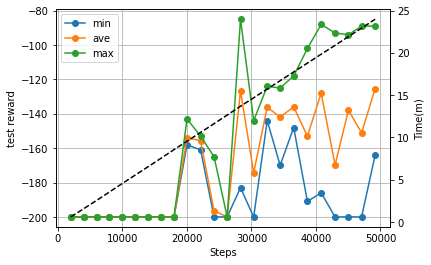

In [ ]:
agent = DQN(**kwargs)
test_agent = DQN(**kwargs)
log = TrainLogger(LoggerType.STEP, 2000, "tmp_{}_log.json".format(ENV_NAME), test_agent, env, test_save_max_reward_file='weight_max_{step:02d}_{reward}.h5')
agent.fit(env, nb_steps=50_000, visualize=False, verbose=0, callbacks=[log])
log.drawGraph("step")

## 2-3.テスト結果(内部報酬無し)

Testing for 5 episodes ...
Episode 1: reward: -139.000, steps: 139
Episode 2: reward: -92.000, steps: 92
Episode 3: reward: -158.000, steps: 158
Episode 4: reward: -183.000, steps: 183
Episode 5: reward: -89.000, steps: 89
Testing for 1 episodes ...
Episode 1: reward: -152.000, steps: 152


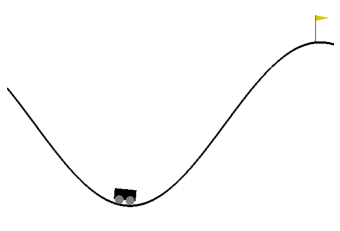

In [ ]:
agent.test(env, nb_episodes=5, visualize=False)
movie = MovieLogger(verbose=0)
agent.test(env, nb_episodes=1, visualize=False, callbacks=[movie])
ani = movie.save(interval=15)
from IPython.display import HTML
HTML(ani.to_jshtml())  # この下にコードを書くと表示されなくなる

## 2-4. 内部報酬を有効にします

In [ ]:
kwargs["enable_intrinsic_reward"] = True

## 2-5.学習の実行(内部報酬あり)

weight save, ave reward:-200.0000
Steps 0, Time: 0.00m, TestReward: -200.00 - -200.00 (ave: -200.00), Reward:   0.00 -   0.00 (ave:   0.00)
Steps 2000, Time: 1.46m, TestReward: -200.00 - -200.00 (ave: -200.00), Reward: -200.00 - -200.00 (ave: -200.00)
Steps 4000, Time: 3.81m, TestReward: -200.00 - -200.00 (ave: -200.00), Reward: -200.00 - -200.00 (ave: -200.00)
Steps 6000, Time: 6.19m, TestReward: -200.00 - -200.00 (ave: -200.00), Reward: -200.00 - -200.00 (ave: -200.00)
Steps 8000, Time: 8.61m, TestReward: -200.00 - -200.00 (ave: -200.00), Reward: -200.00 - -200.00 (ave: -200.00)
Steps 10000, Time: 11.07m, TestReward: -200.00 - -200.00 (ave: -200.00), Reward: -200.00 - -200.00 (ave: -200.00)
Steps 12090, Time: 13.62m, TestReward: -200.00 - -200.00 (ave: -200.00), Reward: -200.00 - -141.00 (ave: -190.00)
weight save, ave reward:-171.7000
Steps 14247, Time: 16.25m, TestReward: -200.00 - -121.00 (ave: -171.70), Reward: -200.00 - -179.00 (ave: -196.09)
weight save, ave reward:-139.6000
St

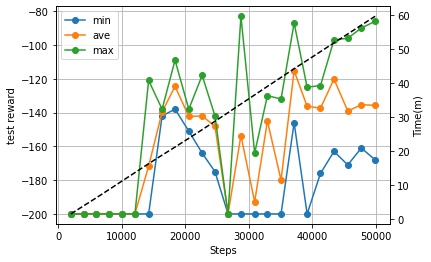

In [ ]:
agent = DQN(**kwargs)
test_agent = DQN(**kwargs)
log = TrainLogger(LoggerType.STEP, 2000, "tmp_{}_log.json".format(ENV_NAME), test_agent, env, test_save_max_reward_file='weight_max_{step:02d}_{reward}.h5')
agent.fit(env, nb_steps=50_000, visualize=False, verbose=0, callbacks=[log])
log.drawGraph("step")

## 2-6.テスト結果(内部報酬あり)

Testing for 5 episodes ...
Episode 1: reward: -177.000, steps: 177
Episode 2: reward: -181.000, steps: 181
Episode 3: reward: -159.000, steps: 159
Episode 4: reward: -180.000, steps: 180
Episode 5: reward: -160.000, steps: 160
Testing for 1 episodes ...
Episode 1: reward: -176.000, steps: 176


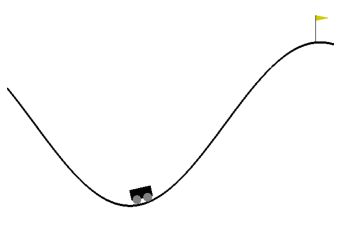

In [ ]:
agent.test(env, nb_episodes=5, visualize=False)
movie = MovieLogger(verbose=0)
agent.test(env, nb_episodes=1, visualize=False, callbacks=[movie])
ani = movie.save(interval=15)
from IPython.display import HTML
HTML(ani.to_jshtml())  # この下にコードを書くと表示されなくなる